In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# --- Karachi coordinates ---
latitude = 24.8608
longitude = 67.0104

# --- Date range ---
start_date = datetime(2023, 1, 1)
end_date = datetime(2025, 10, 11)

# --- AQI Breakpoints (US EPA Standard) ---
breakpoints = {
    "pm2_5": [(0.0,12.0,0,50), (12.1,35.4,51,100), (35.5,55.4,101,150),
              (55.5,150.4,151,200), (150.5,250.4,201,300), (250.5,350.4,301,400), (350.5,500.4,401,500)],
    "pm10":  [(0,54,0,50), (55,154,51,100), (155,254,101,150),
              (255,354,151,200), (355,424,201,300), (425,504,301,400), (505,604,401,500)],
    "ozone": [(0,0.054,0,50), (0.055,0.070,51,100), (0.071,0.085,101,150),
              (0.086,0.105,151,200), (0.106,0.200,201,300)],
    "carbon_monoxide": [(0.0,4.4,0,50), (4.5,9.4,51,100), (9.5,12.4,101,150),
                        (12.5,15.4,151,200), (15.5,30.4,201,300), (30.5,40.4,301,400), (40.5,50.4,401,500)],
    "nitrogen_dioxide": [(0,53,0,50), (54,100,51,100), (101,360,101,150),
                         (361,649,151,200), (650,1249,201,300), (1250,1649,301,400), (1650,2049,401,500)],
    "sulphur_dioxide": [(0,35,0,50), (36,75,51,100), (76,185,101,150),
                        (186,304,151,200), (305,604,201,300), (605,804,301,400), (805,1004,401,500)],
}

# --- AQI Calculation Functions ---
def compute_aqi_for_pollutant(pollutant, conc):
    if pollutant not in breakpoints or pd.isna(conc):
        return None
    for c_lo, c_hi, i_lo, i_hi in breakpoints[pollutant]:
        if c_lo <= conc <= c_hi:
            return ((i_hi - i_lo) / (c_hi - c_lo)) * (conc - c_lo) + i_lo
    return None

def calculate_overall_aqi(row):
    pollutants = ["pm2_5", "pm10", "ozone", "carbon_monoxide", "nitrogen_dioxide", "sulphur_dioxide"]
    aqi_values = []
    for p in pollutants:
        val = compute_aqi_for_pollutant(p, row.get(p))
        if val is not None:
            aqi_values.append(val)
    return max(aqi_values) if aqi_values else None

# --- API Fetch Functions ---
def fetch_aqi(start, end):
    url = (
        "https://air-quality-api.open-meteo.com/v1/air-quality?"
        f"latitude={latitude}&longitude={longitude}"
        f"&start_date={start}&end_date={end}"
        "&hourly=pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone"
    )
    r = requests.get(url).json()
    if "hourly" in r:
        df = pd.DataFrame(r["hourly"])
        df["time"] = pd.to_datetime(df["time"])
        return df
    return pd.DataFrame()

def fetch_weather(start, end):
    url = (
        "https://archive-api.open-meteo.com/v1/archive?"
        f"latitude={latitude}&longitude={longitude}"
        f"&start_date={start}&end_date={end}"
        "&hourly=temperature_2m,relative_humidity_2m,"
        "pressure_msl,wind_speed_10m,cloud_cover"
    )
    r = requests.get(url).json()
    if "hourly" in r:
        df = pd.DataFrame(r["hourly"])
        df["time"] = pd.to_datetime(df["time"])
        return df
    return pd.DataFrame()

# --- Fetch Data in 90-Day Batches ---
aqi_data, weather_data = [], []
current = start_date
while current < end_date:
    next_date = current + timedelta(days=90)
    if next_date > end_date:
        next_date = end_date
    print(f"Fetching {current.date()} → {next_date.date()} ...")

    aqi_df = fetch_aqi(current.date(), next_date.date())
    weather_df = fetch_weather(current.date(), next_date.date())

    if not aqi_df.empty:
        aqi_data.append(aqi_df)
    if not weather_df.empty:
        weather_data.append(weather_df)

    current = next_date + timedelta(days=1)

# --- Combine ---
aqi_final = pd.concat(aqi_data, ignore_index=True)
weather_final = pd.concat(weather_data, ignore_index=True)

# --- Calculate Combined AQI ---
aqi_final["AQI"] = aqi_final.apply(calculate_overall_aqi, axis=1)

# --- Merge AQI + Weather ---
merged = pd.merge_asof(
    aqi_final.sort_values("time"),
    weather_final.sort_values("time"),
    on="time",
    direction="nearest"
)

# --- Reorder Columns ---
cols = [
    "time", "AQI",
    "pm2_5", "pm10", "ozone", "carbon_monoxide", "nitrogen_dioxide", "sulphur_dioxide",
    "temperature_2m", "relative_humidity_2m",
    "pressure_msl", "wind_speed_10m", "cloud_cover"
]
merged = merged[cols]

# --- Save and Display ---
merged.to_csv("karachi_aqi_weather_2023_2025.csv", index=False)
print("\n Data saved as karachi_aqi_weather_2023_2025.csv")
print("Sample preview:\n", merged.head())


Fetching 2023-01-01 → 2023-04-01 ...
Fetching 2023-04-02 → 2023-07-01 ...
Fetching 2023-07-02 → 2023-09-30 ...
Fetching 2023-10-01 → 2023-12-30 ...
Fetching 2023-12-31 → 2024-03-30 ...
Fetching 2024-03-31 → 2024-06-29 ...
Fetching 2024-06-30 → 2024-09-28 ...
Fetching 2024-09-29 → 2024-12-28 ...
Fetching 2024-12-29 → 2025-03-29 ...
Fetching 2025-03-30 → 2025-06-28 ...
Fetching 2025-06-29 → 2025-09-27 ...
Fetching 2025-09-28 → 2025-10-11 ...

 Data saved as karachi_aqi_weather_2023_2025.csv
Sample preview:
                  time         AQI  pm2_5  pm10  ozone  carbon_monoxide  \
0 2023-01-01 00:00:00  103.708543   36.6  61.2   76.0            567.0   
1 2023-01-01 01:00:00   96.004292   33.5  57.0   66.0            668.0   
2 2023-01-01 02:00:00  109.125628   38.8  63.6   53.0            811.0   
3 2023-01-01 03:00:00  113.804020   40.7  66.6   44.0            967.0   
4 2023-01-01 04:00:00  125.623116   45.5  73.3   51.0           1028.0   

   nitrogen_dioxide  sulphur_dioxide  temper

In [3]:
!pip install hopsworks==4.2.*

In [4]:
!pip install "hopsworks[python]" confluent-kafka


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 39.6 MB/s eta 0:00:00


In [5]:
import hopsworks

project = hopsworks.login(api_key_value="TaQcFI5ECxztJQuo.Xkc8vyxvxUc4sFF0wVCpdkwGpUoABnDkkV0xjqf1xzF5xgefSxvMuCr7rC237XFX")
fs = project.get_feature_store()

print(" Connected to:", project.name)


Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1257626
 Connected to: tariqlaiba


In [ ]:
#  Load your dataset
import pandas as pd
data = pd.read_csv("karachi_aqi_weather_2023_2025.csv")

print(" Data loaded successfully!")
print(data.head())


In [ ]:
#  Create a feature group (like a table)
aqi_fg = fs.get_or_create_feature_group(
    name="karachi_aqi_weather",
    version=1,
    description="Historical AQI and weather data for Karachi (2023–2025)",
    primary_key=["time"],      # unique identifier
    event_time="time"          # timestamp column
)


In [ ]:
#  Insert your data into the feature group
aqi_fg.insert(data)

print(" Data uploaded successfully to Hopsworks Feature Store!")


In [ ]:
import hopsworks
import os

api_key = os.getenv("TaQcFI5ECxztJQuo.Xkc8vyxvxUc4sFF0wVCpdkwGpUoABnDkkV0xjqf1xzF5xgefSxvMuCr7rC237XFX")  # ya apna key directly
project = hopsworks.login(api_key_value=api_key)
fs = project.get_feature_store()

fg = fs.get_feature_group(name="karachi_aqi_weather", version=1)
df= fg.read()
print(df.tail(5))  # last 5 records


Connection closed.
Copy your Api Key (first register/login): https://c.app.hopsworks.ai/account/api/generated

Paste it here: ··········

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1257626
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.85s) 
                           time        aqi  pm2_5  pm10  ozone  \
24931 2025-11-04 18:00:00+00:00  78.339056   25.1  41.3   57.0   
24932 2025-11-04 01:00:00+00:00  94.532189   32.8  45.4   34.0   
24933 2025-11-04 09:00:00+00:00  75.184549   23.6  43.7  127.0   
24934 2025-11-04 08:00:00+00:00  76.025751   24.0  46.3  124.0   
24935 2025-11-04 20:00:00+00:00  78.339056   25.1  43.0   44.0   

       carbon_monoxide  nitrogen_dioxide  sulphur_dioxide  temperature_2m  \
24931            335.0              25.1             16.4            25.8   
24932            446.0              20.4              9.6            21.4   
24933            272.0               4.6             11.9            

# Exploratory Data Analysis

In [ ]:
print("\nDataset Shape:")
print(df.shape)

print("\nDataset Columns:")
print(df.columns)

print("\nDataset Info:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())

print("\nMissing values in each column:")
print(df.isnull().sum())



Dataset Shape:
(24936, 13)

Dataset Columns:
Index(['time', 'aqi', 'pm2_5', 'pm10', 'ozone', 'carbon_monoxide',
       'nitrogen_dioxide', 'sulphur_dioxide', 'temperature_2m',
       'relative_humidity_2m', 'pressure_msl', 'wind_speed_10m',
       'cloud_cover'],
      dtype='object')

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24936 entries, 0 to 24935
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype                  
---  ------                --------------  -----                  
 0   time                  24936 non-null  datetime64[us, Etc/UTC]
 1   aqi                   24936 non-null  float64                
 2   pm2_5                 24936 non-null  float64                
 3   pm10                  24936 non-null  float64                
 4   ozone                 24936 non-null  float64                
 5   carbon_monoxide       24936 non-null  float64                
 6   nitrogen_dioxide      24936 non-null  float64   

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


# Basic Data Cleaning

In [ ]:
# Handle duplicates
df = df.drop_duplicates()

# If any missing values, fill using time-based interpolation
df = df.sort_values('time').set_index('time')
df = df.interpolate(method='time').ffill().bfill().reset_index()

print("Missing values handled & duplicates removed")

Missing values handled & duplicates removed


# Feature Engineering (Datetime Columns)

In [ ]:
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['hour'] = df['time'].dt.hour
df['weekday'] = df['time'].dt.weekday

df.head()


,time,aqi,pm2_5,pm10,ozone,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,temperature_2m,relative_humidity_2m,pressure_msl,wind_speed_10m,cloud_cover,year,month,day,hour,weekday
0,2023-01-01 00:00:00+00:00,103.708543,36.6,61.2,76.0,567.0,23.0,27.0,15.6,84,1019.1,10.1,0,2023,1,1,0,6
1,2023-01-01 01:00:00+00:00,96.004292,33.5,57.0,66.0,668.0,30.2,30.4,14.6,89,1019.5,9.6,4,2023,1,1,1,6
2,2023-01-01 02:00:00+00:00,109.125628,38.8,63.6,53.0,811.0,40.5,35.2,14.8,89,1020.0,10.7,13,2023,1,1,2,6
3,2023-01-01 03:00:00+00:00,113.804020,40.7,66.6,44.0,967.0,50.4,41.0,15.9,82,1020.6,11.5,3,2023,1,1,3,6
4,2023-01-01 04:00:00+00:00,125.623116,45.5,73.3,51.0,1028.0,52.1,44.2,18.1,64,1021.3,9.6,0,2023,1,1,4,6


# Univariate Distribution

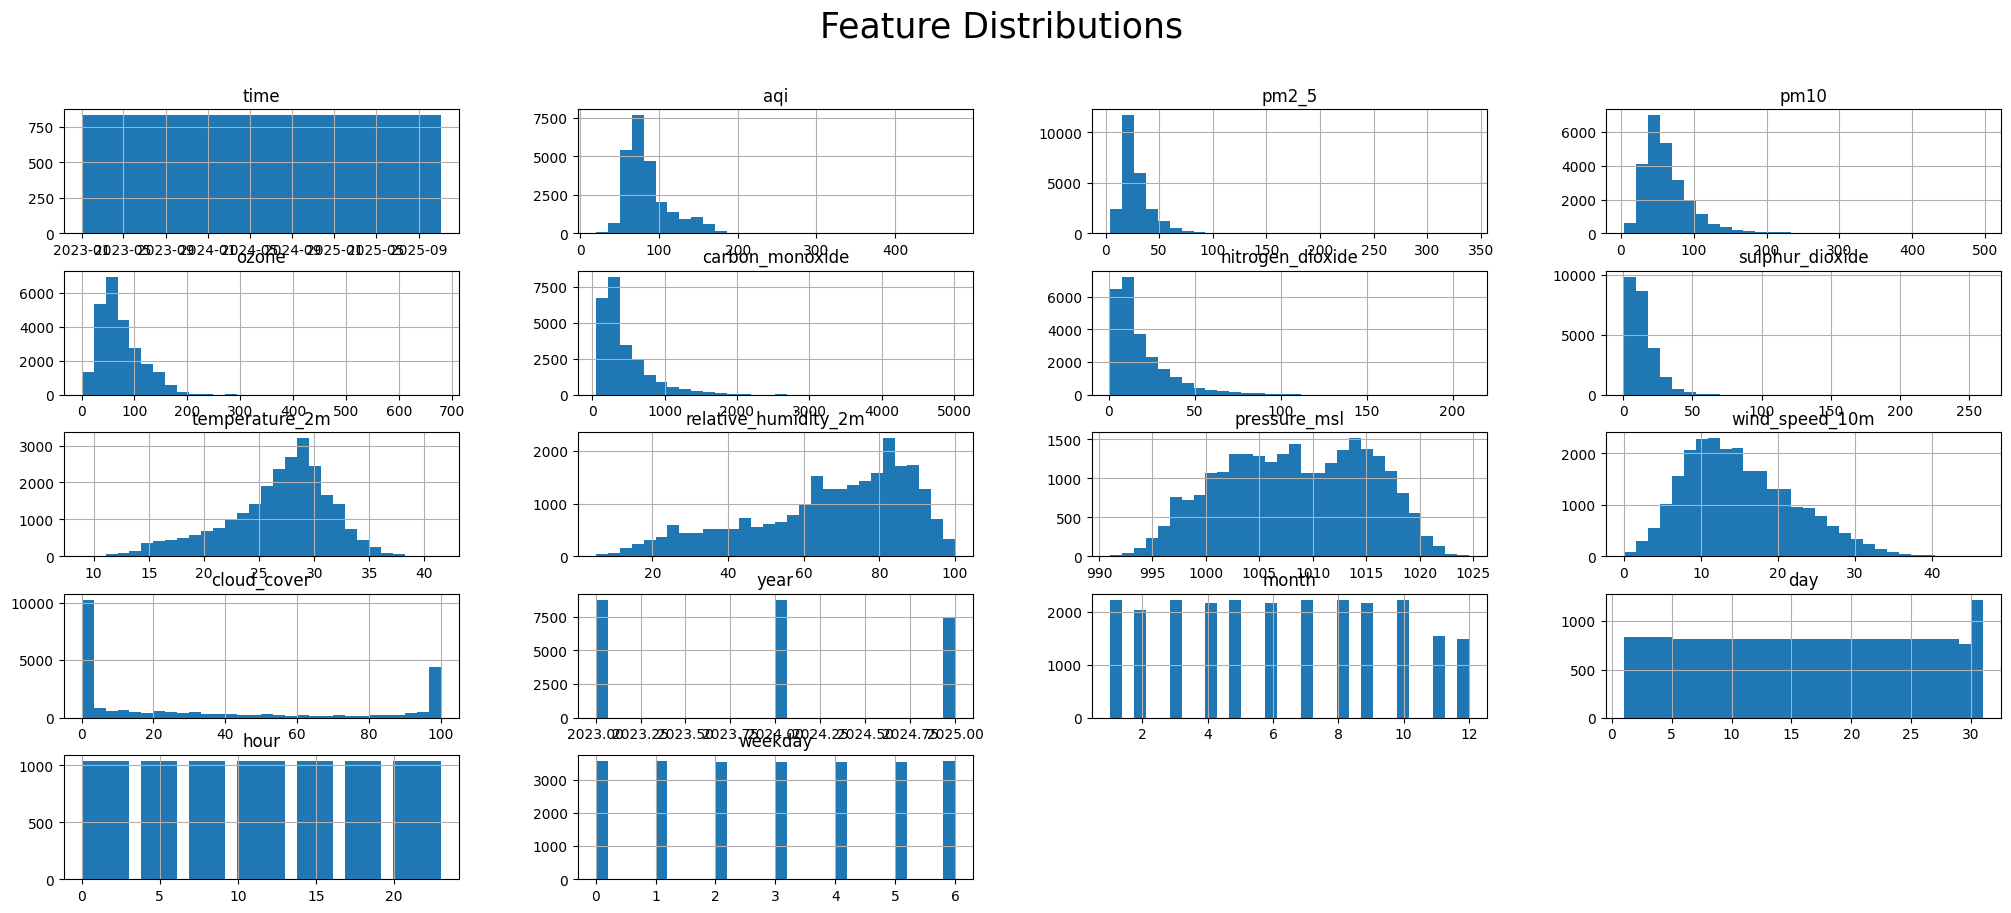

In [ ]:
df.hist(figsize=(25,10), bins=30)
plt.suptitle("Feature Distributions", fontsize=25)
plt.show()


# Outlier Detection

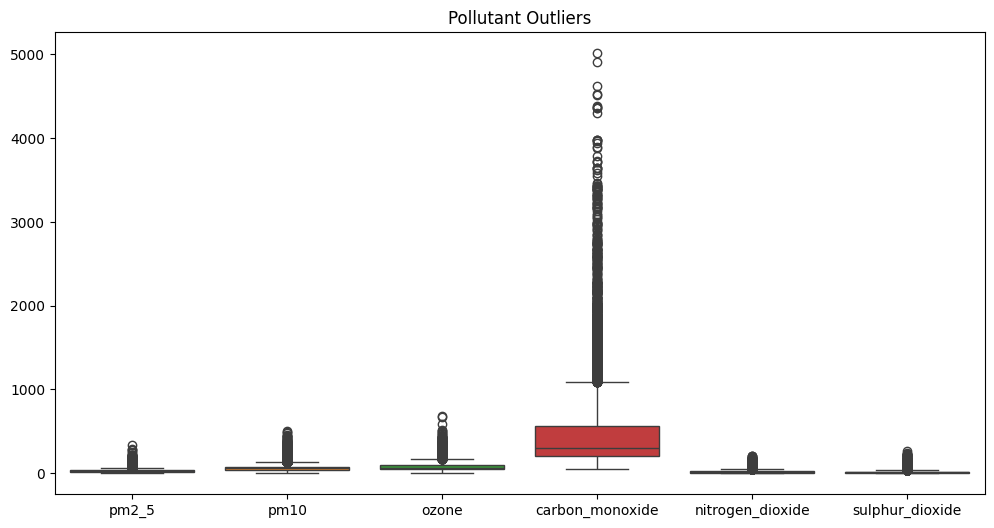

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df[['pm2_5','pm10','ozone','carbon_monoxide','nitrogen_dioxide','sulphur_dioxide']])
plt.title("Pollutant Outliers")
plt.show()


# Correlation Matrix

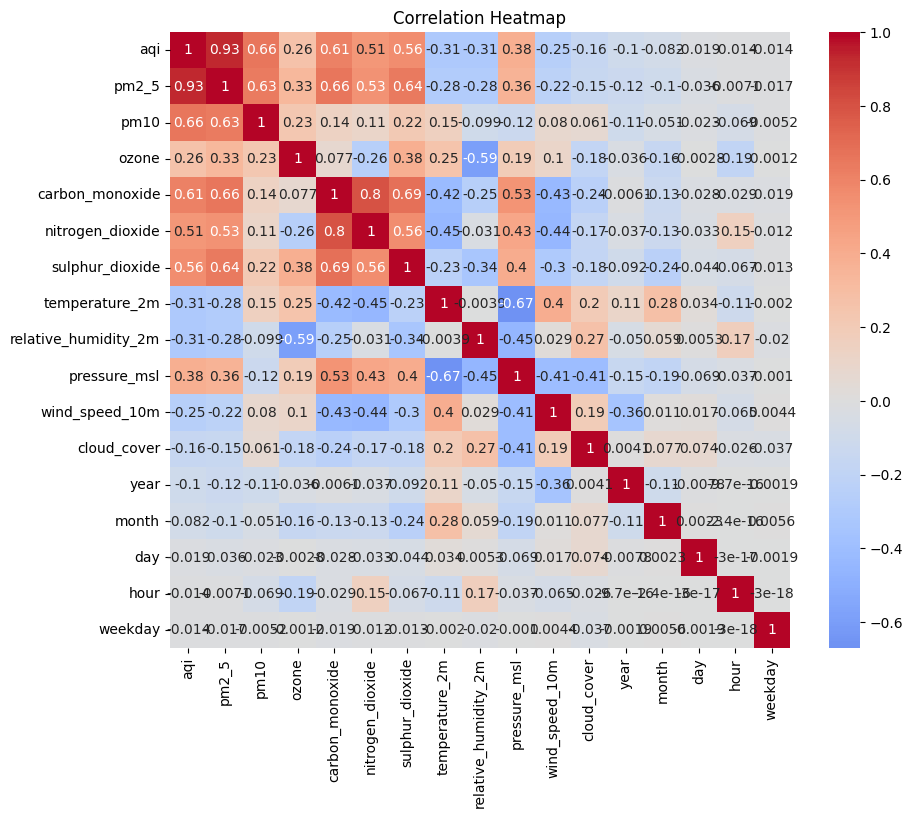

In [ ]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


# Time Trend Analysis

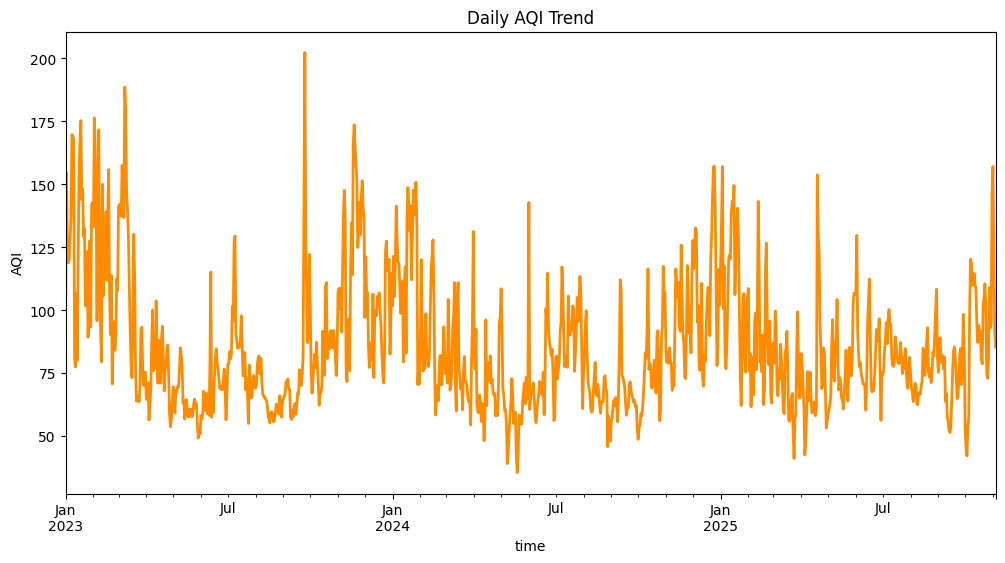

In [ ]:
df.set_index('time', inplace=True)
df['aqi'].resample('D').mean().plot(figsize=(12,6), color='darkorange', lw=2)
plt.title("Daily AQI Trend")
plt.ylabel("AQI")
plt.show()


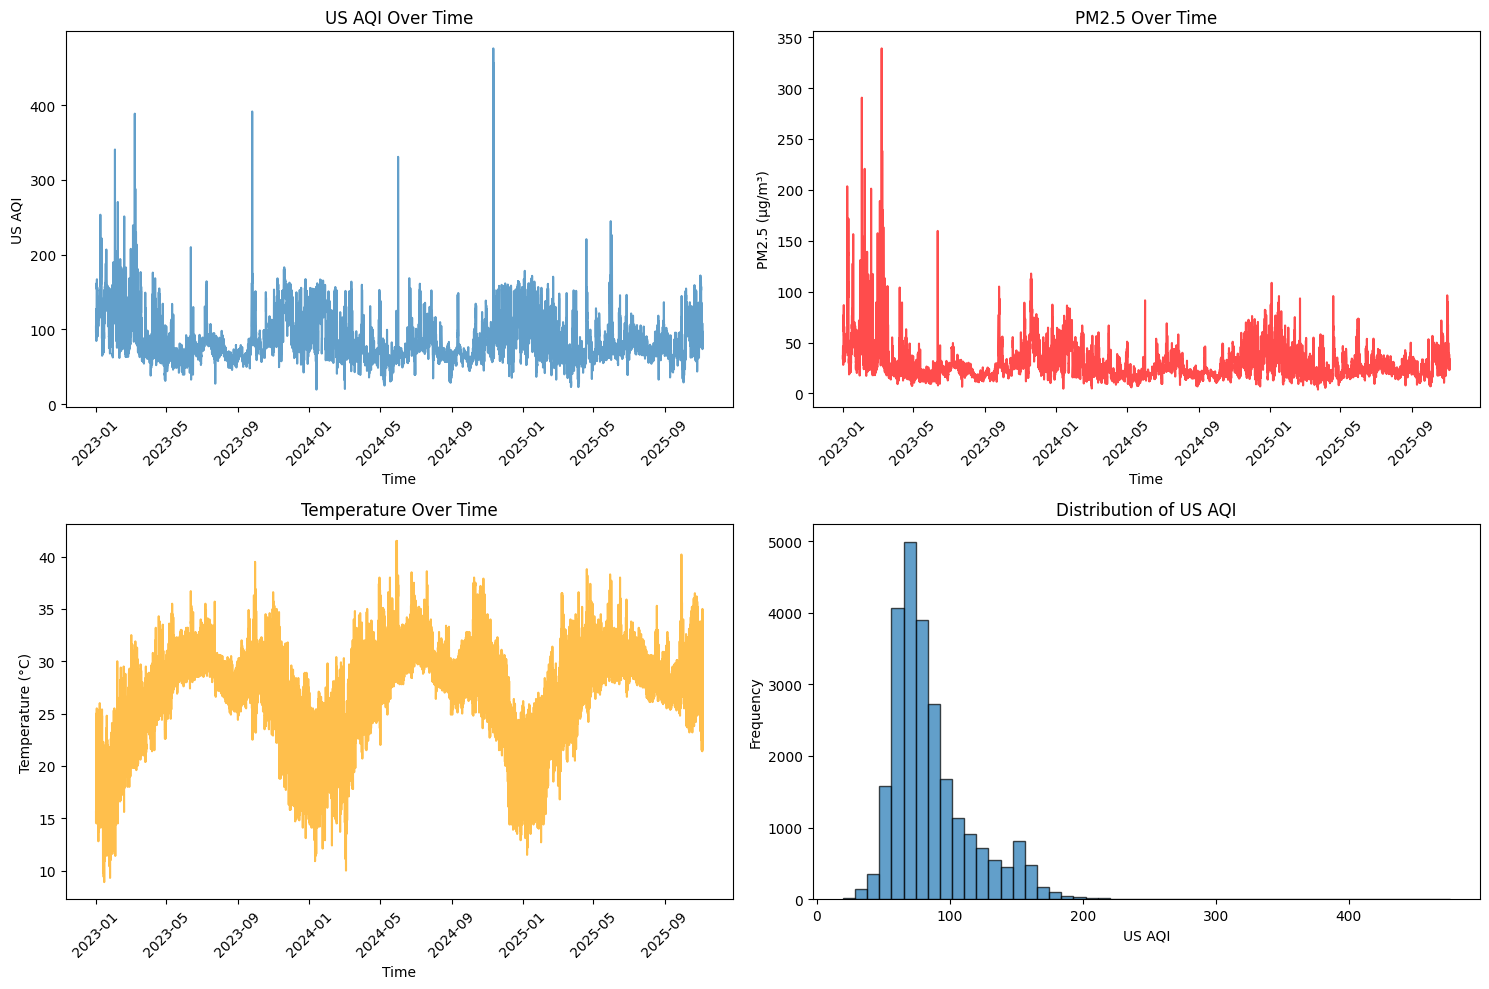

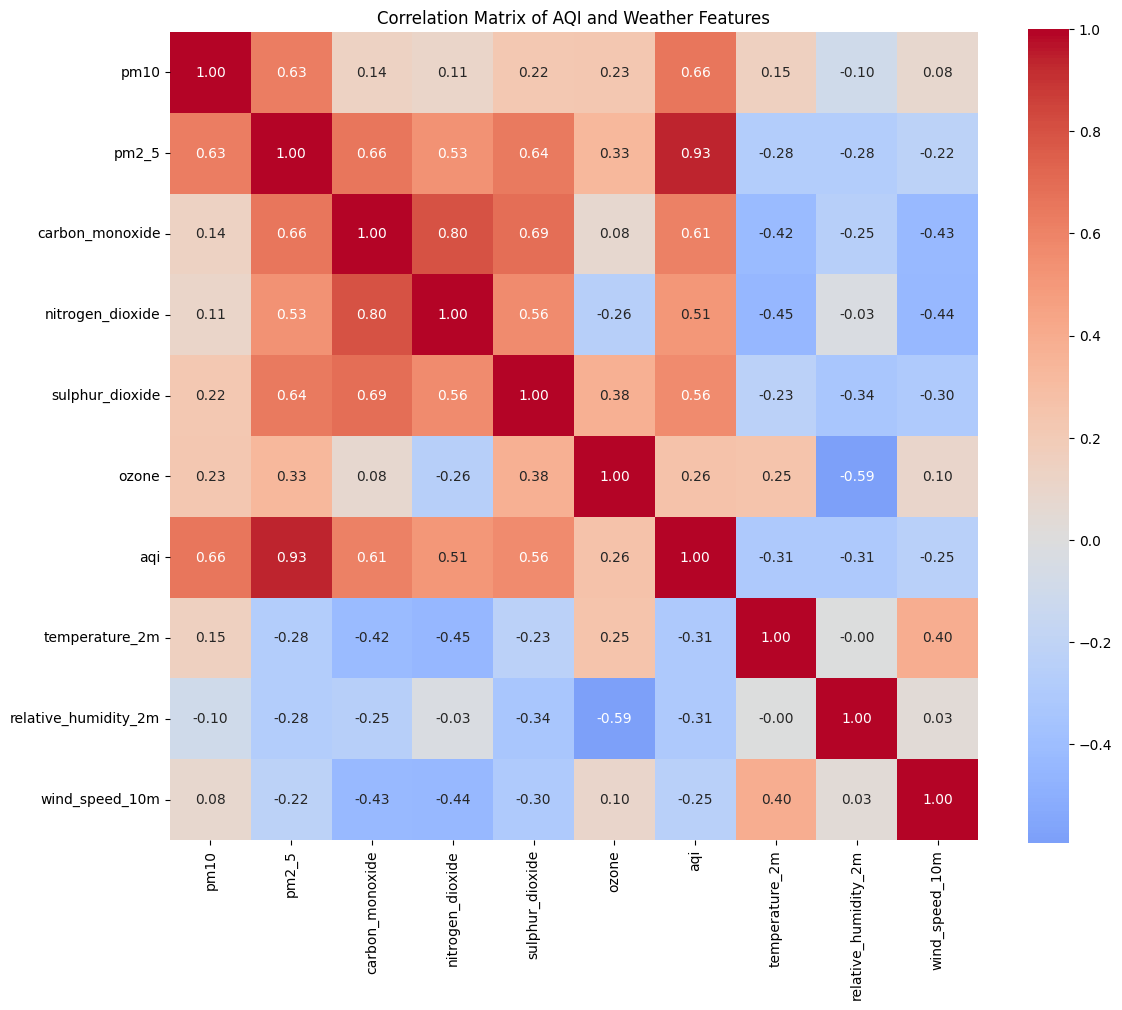

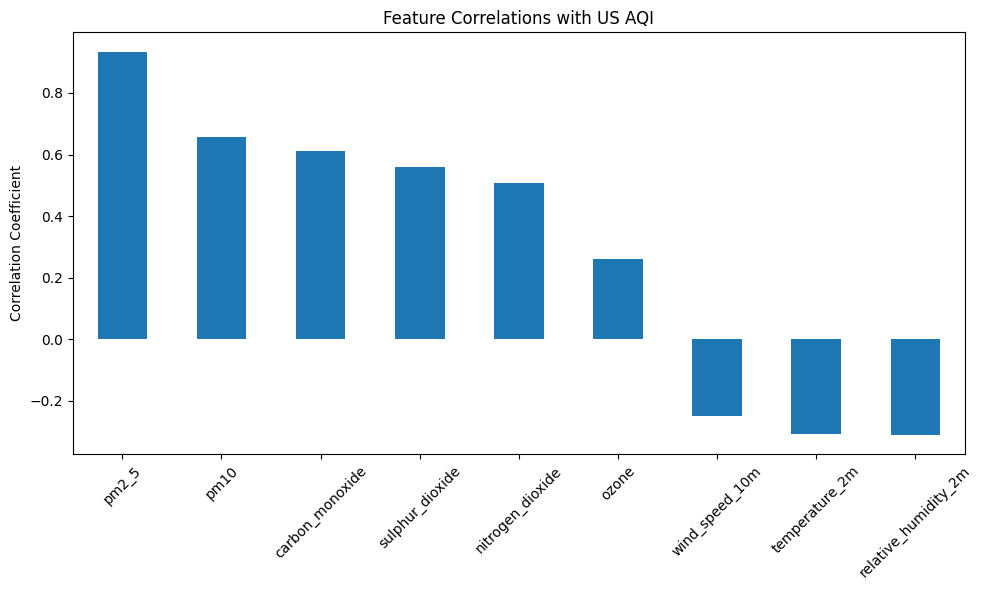

In [ ]:
#visualizations
def plot_aqi_trends(df):
    """Plot AQI trends over time"""
    plt.figure(figsize=(15, 10))

    # Plot 1: US AQI over time
    plt.subplot(2, 2, 1)
    plt.plot(df.reset_index()['time'], df['aqi'], alpha=0.7)
    plt.title('US AQI Over Time')
    plt.xlabel('Time')
    plt.ylabel('US AQI')
    plt.xticks(rotation=45)

    # Plot 2: PM2.5 over time
    plt.subplot(2, 2, 2)
    plt.plot(df.reset_index()['time'], df['pm2_5'], alpha=0.7, color='red')
    plt.title('PM2.5 Over Time')
    plt.xlabel('Time')
    plt.ylabel('PM2.5 (μg/m³)')
    plt.xticks(rotation=45)

    # Plot 3: Temperature over time
    plt.subplot(2, 2, 3)
    plt.plot(df.reset_index()['time'], df['temperature_2m'], alpha=0.7, color='orange')
    plt.title('Temperature Over Time')
    plt.xlabel('Time')
    plt.ylabel('Temperature (°C)')
    plt.xticks(rotation=45)

    # Plot 4: Histogram of US AQI
    plt.subplot(2, 2, 4)
    plt.hist(df['aqi'], bins=50, alpha=0.7, edgecolor='black')
    plt.title('Distribution of US AQI')
    plt.xlabel('US AQI')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def plot_correlations(df):
    """Plot correlation matrix of features"""
    # Select numerical columns for correlation
    numerical_cols = ['pm10', 'pm2_5', 'carbon_monoxide', 'nitrogen_dioxide',
                     'sulphur_dioxide', 'ozone', 'aqi', 'temperature_2m',
                     'relative_humidity_2m', 'wind_speed_10m']

    correlation_matrix = df[numerical_cols].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f')
    plt.title('Correlation Matrix of AQI and Weather Features')
    plt.tight_layout()
    plt.show()

    # Plot correlation with target (US AQI)
    aqi_correlations = correlation_matrix['aqi'].sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    aqi_correlations.drop('aqi').plot(kind='bar')
    plt.title('Feature Correlations with US AQI')
    plt.ylabel('Correlation Coefficient')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_aqi_trends(df)
plot_correlations(df)

In [ ]:
skew_vals = df.skew(numeric_only=True)
print(skew_vals.sort_values())


relative_humidity_2m   -0.734645
temperature_2m         -0.719429
pressure_msl           -0.105450
hour                    0.000000
weekday                 0.001925
day                     0.010707
month                   0.044418
year                    0.099323
wind_speed_10m          0.610094
cloud_cover             0.682897
aqi                     1.693492
ozone                   2.049420
nitrogen_dioxide        2.581134
pm10                    2.681358
carbon_monoxide         3.124846
pm2_5                   3.590223
sulphur_dioxide         5.566395
dtype: float64


# Outlier Removal

Before: (24936, 17)
After: (24936, 17)


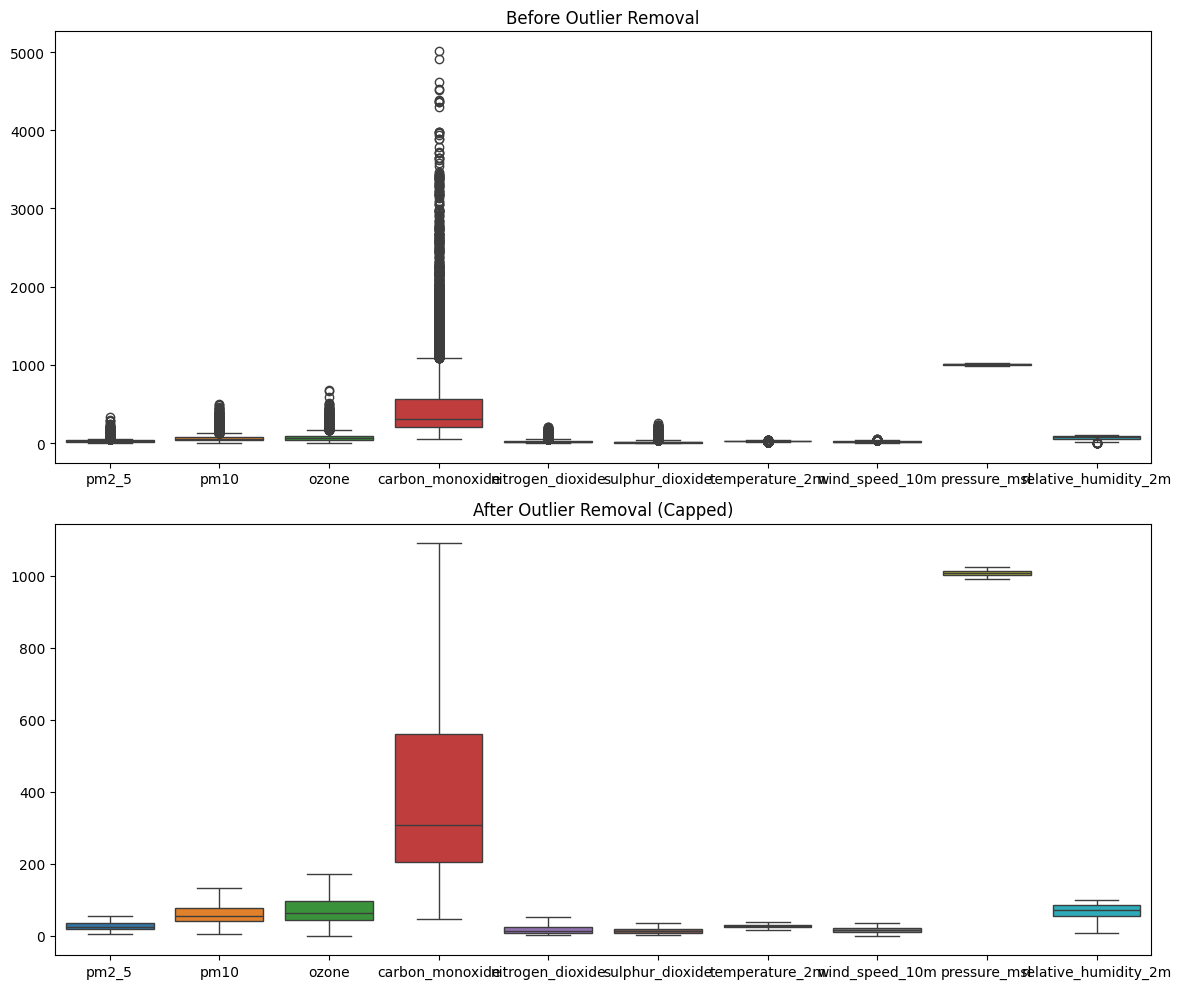

In [ ]:
# ---- Select numeric pollutant columns ----
pollutant_cols = [
    'pm2_5', 'pm10', 'ozone',
    'carbon_monoxide', 'nitrogen_dioxide', 'sulphur_dioxide','temperature_2m','wind_speed_10m','pressure_msl','relative_humidity_2m'
]

# ---- Step 1: Function for removing outliers using IQR ----
def remove_outliers_iqr(df, columns, method="remove"):
    """
    method = "remove"  -> drop rows containing outliers
    method = "cap"     -> cap outlier values to upper/lower bounds
    """
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        if method == "remove":
            df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
        elif method == "cap":
            df_clean[col] = np.where(df_clean[col] > upper, upper,
                                     np.where(df_clean[col] < lower, lower, df_clean[col]))
        else:
            raise ValueError("method must be 'remove' or 'cap'")
    return df_clean

# ---- Step 2: Run the function ----
df_no_outliers = remove_outliers_iqr(df, pollutant_cols, method="cap")  # use "remove" if you want to drop

print("Before:", df.shape)
print("After:", df_no_outliers.shape)

# ---- Step 3: Visualize before and after ----
fig, axes = plt.subplots(2, 1, figsize=(12,10))

sns.boxplot(data=df[pollutant_cols], ax=axes[0])
axes[0].set_title("Before Outlier Removal")

sns.boxplot(data=df_no_outliers[pollutant_cols], ax=axes[1])
axes[1].set_title("After Outlier Removal (Capped)")

plt.tight_layout()
plt.show()


In [ ]:
df_no_outliers.to_csv("cleaned_aqi.csv")
print(" Cleaned dataset saved to: cleaned_aqi.csv")

✅ Cleaned dataset saved to: cleaned_aqi.csv


In [ ]:
df_no_outliers.tail()

,aqi,pm2_5,pm10,ozone,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,temperature_2m,relative_humidity_2m,pressure_msl,wind_speed_10m,cloud_cover,year,month,day,hour,weekday
time,,,,,,,,,,,,,,,,,
2025-11-04 19:00:00+00:00,77.918455,24.9,44.8,52.0,286.0,23.4,15.2,24.8,13.0,1010.1,14.7,0,2025,11,4,19,1
2025-11-04 20:00:00+00:00,78.339056,25.1,43.0,44.0,262.0,23.0,13.5,23.7,14.0,1009.9,13.5,0,2025,11,4,20,1
2025-11-04 21:00:00+00:00,78.128755,25.0,37.4,40.0,244.0,22.4,11.9,22.6,16.0,1009.6,12.7,0,2025,11,4,21,1
2025-11-04 22:00:00+00:00,76.866953,24.4,31.7,43.0,227.0,20.0,10.6,21.9,18.0,1009.5,13.1,0,2025,11,4,22,1
2025-11-04 23:00:00+00:00,77.287554,24.6,29.2,48.0,217.0,17.2,9.5,21.6,21.0,1009.5,13.5,0,2025,11,4,23,1


In [ ]:
#  Save cleaned DataFrame to CSV
output_path = "cleaned_aqi_weather.csv"
df_no_outliers.to_csv(output_path, index=False)

print(f" Cleaned dataset with new features saved to: {output_path}")
print(f" Final shape: {df_no_outliers.shape}")
df_no_outliers.tail()

✅ Cleaned dataset with new features saved to: cleaned_aqi_weather.csv
🧩 Final shape: (24936, 17)


,aqi,pm2_5,pm10,ozone,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,temperature_2m,relative_humidity_2m,pressure_msl,wind_speed_10m,cloud_cover,year,month,day,hour,weekday
time,,,,,,,,,,,,,,,,,
2025-11-04 19:00:00+00:00,77.918455,24.9,44.8,52.0,286.0,23.4,15.2,24.8,13.0,1010.1,14.7,0,2025,11,4,19,1
2025-11-04 20:00:00+00:00,78.339056,25.1,43.0,44.0,262.0,23.0,13.5,23.7,14.0,1009.9,13.5,0,2025,11,4,20,1
2025-11-04 21:00:00+00:00,78.128755,25.0,37.4,40.0,244.0,22.4,11.9,22.6,16.0,1009.6,12.7,0,2025,11,4,21,1
2025-11-04 22:00:00+00:00,76.866953,24.4,31.7,43.0,227.0,20.0,10.6,21.9,18.0,1009.5,13.1,0,2025,11,4,22,1
2025-11-04 23:00:00+00:00,77.287554,24.6,29.2,48.0,217.0,17.2,9.5,21.6,21.0,1009.5,13.5,0,2025,11,4,23,1


In [ ]:
# ============================================================
#  Load your cleaned CSV
# ============================================================
df_1 = pd.read_csv("cleaned_aqi.csv")

# Ensure 'time' column is string (Hopsworks expects string type)
if "time" in df_1.columns:
   df_1["time"] = pd.to_datetime(df_1["time"], errors="coerce")


print(" Cleaned CSV loaded successfully!")
print("Shape:", df_1.shape)
print("Columns:", df_1.columns.tolist())

# ============================================================
#  Create or get Feature Group
# ============================================================
cleaned_fg = fs.get_or_create_feature_group(
    name="cleaned_aqi_data",
    version=1,  # increment if schema changes
    primary_key=["time"],  # must be unique
    description="Cleaned AQI and weather dataset (outliers, skewness removed)"
)

# ============================================================
#  Upload to Feature Store
# ============================================================
cleaned_fg.insert(df_1, write_options={"wait_for_job": False})

print(" Successfully uploaded cleaned data to Feature Store!")


✅ Cleaned CSV loaded successfully!
Shape: (24936, 18)
Columns: ['time', 'aqi', 'pm2_5', 'pm10', 'ozone', 'carbon_monoxide', 'nitrogen_dioxide', 'sulphur_dioxide', 'temperature_2m', 'relative_humidity_2m', 'pressure_msl', 'wind_speed_10m', 'cloud_cover', 'year', 'month', 'day', 'hour', 'weekday']
Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1257626/fs/1245252/fg/1595997


Uploading Dataframe: 100.00% |██████████| Rows 24936/24936 | Elapsed Time: 00:02 | Remaining Time: 00:00


Launching job: cleaned_aqi_data_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1257626/jobs/named/cleaned_aqi_data_1_offline_fg_materialization/executions
🚀 Successfully uploaded cleaned data to Feature Store!


In [ ]:
import hopsworks
import pandas as pd


# ============================================================
# Get your existing feature group
# ============================================================
cleaned_fg = fs.get_feature_group(
    name="cleaned_aqi_data",
    version=1
)

# ============================================================
#  Fetch data into a Pandas DataFrame
# ============================================================
df = cleaned_fg.read()

# ============================================================
#  Confirm successful retrieval
# ============================================================
print(" Data successfully fetched from Feature Store!")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
preview=df.sort_values(by='time')
print(preview.head())



Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (25.04s) 
 Data successfully fetched from Feature Store!
Shape: (24984, 18)
Columns: ['time', 'aqi', 'pm2_5', 'pm10', 'ozone', 'carbon_monoxide', 'nitrogen_dioxide', 'sulphur_dioxide', 'temperature_2m', 'relative_humidity_2m', 'pressure_msl', 'wind_speed_10m', 'cloud_cover', 'year', 'month', 'day', 'hour', 'weekday']
                           time         aqi  pm2_5  pm10  ozone  \
2500  2023-01-01 00:00:00+00:00  103.708543   36.6  61.2   76.0   
24322 2023-01-01 01:00:00+00:00   96.004292   33.5  57.0   66.0   
805   2023-01-01 02:00:00+00:00  109.125628   38.8  63.6   53.0   
540   2023-01-01 03:00:00+00:00  113.804020   40.7  66.6   44.0   
3208  2023-01-01 04:00:00+00:00  125.623116   45.5  73.3   51.0   

       carbon_monoxide  nitrogen_dioxide  sulphur_dioxide  temperature_2m  \
2500             567.0             23.00             27.0           15.60   
24322            668.0             30.20       

In [ ]:
print(preview.tail)



<bound method NDFrame.tail of                            time         aqi  pm2_5  pm10  ozone  \
2500  2023-01-01 00:00:00+00:00  103.708543   36.6  61.2   76.0   
24322 2023-01-01 01:00:00+00:00   96.004292   33.5  57.0   66.0   
805   2023-01-01 02:00:00+00:00  109.125628   38.8  63.6   53.0   
540   2023-01-01 03:00:00+00:00  113.804020   40.7  66.6   44.0   
3208  2023-01-01 04:00:00+00:00  125.623116   45.5  73.3   51.0   
...                         ...         ...    ...   ...    ...   
24963 2025-11-06 19:00:00+00:00  151.000000   55.5  74.0   17.0   
24970 2025-11-06 20:00:00+00:00  146.798995   54.1  72.6   16.0   
24966 2025-11-06 21:00:00+00:00  134.487437   49.1  65.2   19.0   
24982 2025-11-06 22:00:00+00:00  118.236181   42.5  57.6   29.0   
24973 2025-11-06 23:00:00+00:00  105.432161   37.3  52.2   43.0   

       carbon_monoxide  nitrogen_dioxide  sulphur_dioxide  temperature_2m  \
2500             567.0             23.00             27.0           15.60   
24322      

In [ ]:
print(df.columns)

Index(['time', 'aqi', 'pm2_5', 'pm10', 'ozone', 'carbon_monoxide',
       'nitrogen_dioxide', 'sulphur_dioxide', 'temperature_2m',
       'relative_humidity_2m', 'pressure_msl', 'wind_speed_10m', 'cloud_cover',
       'year', 'month', 'day', 'hour', 'weekday'],
      dtype='object')


In [ ]:
df.isnull().sum()

,0
time,0
aqi,0
pm2_5,0
pm10,0
ozone,0
carbon_monoxide,0
nitrogen_dioxide,0
sulphur_dioxide,0
temperature_2m,0
relative_humidity_2m,0


# Feature Engineering

In [ ]:
# ============================================================
#  FEATURE ENGINEERING + VISUALIZATION — AQI 3-Day Forecast
# ============================================================


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ------------------------------------------------------------
#  Detect and process datetime features
# ------------------------------------------------------------
def process_datetime_features(df):
    """
    Detects datetime column automatically and extracts time-based features
    + cyclical encoding for periodicity.
    """
    df = df.copy()
    time_col = None
    for col in df.columns:
        if col.lower() in ['time', 'timestamp', 'datetime', 'date']:
            time_col = col
            break

    if time_col:
        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
        df['year'] = df[time_col].dt.year
        df['month'] = df[time_col].dt.month
        df['day'] = df[time_col].dt.day
        df['hour'] = df[time_col].dt.hour
        df['weekday'] = df[time_col].dt.weekday
        df['day_of_year'] = df[time_col].dt.dayofyear
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        df.drop(columns=[time_col], inplace=True)
        print(f" Extracted datetime features from '{time_col}'")
    else:
        print(" No time column found — skipping datetime extraction.")
    return df


# ------------------------------------------------------------
#  Generate and encode season features
# ------------------------------------------------------------
def add_and_encode_season(df):
    df = df.copy()
    if 'month' in df.columns and 'season' not in df.columns:
        def assign_season(m):
            if m in [12, 1, 2]:
                return 'winter'
            elif m in [3, 4, 5]:
                return 'spring'
            elif m in [6, 7, 8]:
                return 'summer'
            else:
                return 'autumn'
        df['season'] = df['month'].apply(assign_season)
        print("🌦 Added 'season' column from 'month'.")

    if 'season' in df.columns:
        df = pd.get_dummies(df, columns=['season'], prefix='season', dtype=float)
        print(" One-hot encoded 'season' column.")
    else:
        print(" 'season' column not found — skipping encoding.")
    return df


# ------------------------------------------------------------
#  Add AQI lag and rolling features
# ------------------------------------------------------------
def add_aqi_lag_features(df):
    df = df.copy()
    aqi_col = None
    for col in df.columns:
        if col.lower() == 'aqi':
            aqi_col = col
            break
    if aqi_col:
        df[f'{aqi_col}_lag1'] = df[aqi_col].shift(1)
        df[f'{aqi_col}_lag2'] = df[aqi_col].shift(2)
        df[f'{aqi_col}_rolling_mean3'] = df[aqi_col].rolling(window=3).mean()
        df[f'{aqi_col}_diff'] = df[aqi_col].diff()
        print(" Added AQI lag and rolling features.")
    else:
        print(" 'AQI' column not found — skipping lag features.")
    return df


# ------------------------------------------------------------
#  Add target columns (for predicting next 3 days)
# ------------------------------------------------------------
def add_prediction_targets(df):
    df = df.copy()
    for c in df.columns:
        if c.lower() == 'aqi':
            aqi_col = c
            break
    else:
        print(" 'AQI' column not found — skipping targets.")
        return df

    df['target_AQI_t+1'] = df[aqi_col].shift(-1)
    df['target_AQI_t+2'] = df[aqi_col].shift(-2)
    df['target_AQI_t+3'] = df[aqi_col].shift(-3)
    print(" Added 3-day ahead target columns for AQI.")
    return df

# ------------------------------------------------------------
#  Full feature-engineering pipeline
# ------------------------------------------------------------
def run_feature_engineering(df_cleaned):
    df = df_cleaned.copy()
    df = process_datetime_features(df)
    df = add_and_encode_season(df)
    df = add_aqi_lag_features(df)
    df = add_prediction_targets(df)

    non_numeric = df.select_dtypes(exclude=[np.number]).columns
    if len(non_numeric) > 0:
        print(f" Dropping non-numeric columns: {list(non_numeric)}")
        df = df.drop(columns=non_numeric)

    df = df.dropna().reset_index(drop=True)
    print(f"\n Final engineered feature matrix shape: {df.shape}")
    return df



In [ ]:
df_feature =run_feature_engineering(preview)
df_feature.tail()

 Extracted datetime features from 'time'
🌦 Added 'season' column from 'month'.
 One-hot encoded 'season' column.
 Added AQI lag and rolling features.
 Added 3-day ahead target columns for AQI.

 Final engineered feature matrix shape: (24979, 31)


,aqi,pm2_5,pm10,ozone,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,temperature_2m,relative_humidity_2m,pressure_msl,...,season_spring,season_summer,season_winter,aqi_lag1,aqi_lag2,aqi_rolling_mean3,aqi_diff,target_AQI_t+1,target_AQI_t+2,target_AQI_t+3
24974,116.266332,41.7,55.2,47.0,1092.5,51.15,17.0,24.2,72.0,1013.9,...,0.0,0.0,0.0,114.788945,117.743719,116.266332,1.477387,127.592965,144.336683,151.000000
24975,127.592965,46.3,61.5,33.0,1092.5,51.15,19.6,23.4,76.0,1014.0,...,0.0,0.0,0.0,116.266332,114.788945,119.549414,11.326633,144.336683,151.000000,146.798995
24976,144.336683,53.1,70.5,23.0,1092.5,51.15,21.2,22.5,78.0,1014.0,...,0.0,0.0,0.0,127.592965,116.266332,129.398660,16.743719,151.000000,146.798995,134.487437
24977,151.000000,55.5,74.0,17.0,1092.5,51.15,20.7,21.6,80.0,1014.0,...,0.0,0.0,0.0,144.336683,127.592965,140.976549,6.663317,146.798995,134.487437,118.236181
24978,146.798995,54.1,72.6,16.0,916.0,51.15,19.3,20.6,81.0,1013.7,...,0.0,0.0,0.0,151.000000,144.336683,147.378559,-4.201005,134.487437,118.236181,105.432161


In [ ]:
df_feature.columns

Index(['aqi', 'pm2_5', 'pm10', 'ozone', 'carbon_monoxide', 'nitrogen_dioxide',
       'sulphur_dioxide', 'temperature_2m', 'relative_humidity_2m',
       'pressure_msl', 'wind_speed_10m', 'cloud_cover', 'year', 'month', 'day',
       'hour', 'weekday', 'day_of_year', 'month_sin', 'month_cos',
       'season_autumn', 'season_spring', 'season_summer', 'season_winter',
       'aqi_lag1', 'aqi_lag2', 'aqi_rolling_mean3', 'aqi_diff',
       'target_AQI_t+1', 'target_AQI_t+2', 'target_AQI_t+3'],
      dtype='object')

In [ ]:
output_path = "feature_engineered_aqi.csv"
df_feature.to_csv(output_path, index=False)

print(f" Feature engineered dataset saved to: {output_path}")
print(f" Final shape: {df_feature.shape}")

 Feature engineered dataset saved to: feature_engineered_aqi.csv
 Final shape: (24955, 31)


In [ ]:
import hopsworks

# Rename invalid columns
df_feature = df_feature.rename(columns={
    "target_AQI_t+1": "target_aqi_t1",
    "target_AQI_t+2": "target_aqi_t2",
    "target_AQI_t+3": "target_aqi_t3"
})
df_feature.columns = df_feature.columns.str.lower()

# Connect and upload
project = hopsworks.login()
fs = project.get_feature_store()

primary_key = ["year", "month", "day", "hour"]

aqi_fg = fs.get_or_create_feature_group(
    name="aqi_feature_engineered",
    version=2,
    description="Feature-engineered AQI dataset with lags and temporal features",
    primary_key=primary_key,
    online_enabled=True
)

aqi_fg.insert(df_feature)

print(" Successfully uploaded engineered features to Hopsworks Feature Store!")


Connection closed.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1257626
Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1257626/fs/1245252/fg/1595998


Uploading Dataframe: 100.00% |██████████| Rows 24931/24931 | Elapsed Time: 00:02 | Remaining Time: 00:00


Launching job: aqi_feature_engineered_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1257626/jobs/named/aqi_feature_engineered_2_offline_fg_materialization/executions
✅ Successfully uploaded engineered features to Hopsworks Feature Store!


# Feature Selection

Using 28 numeric features for model-based selection.

Training Multi-Output Random Forest...
 Top 15 Tree-Based Important Features:
 - aqi
 - aqi_diff
 - pm2_5
 - hour
 - sulphur_dioxide
 - wind_speed_10m
 - aqi_lag2
 - day_of_year
 - ozone
 - relative_humidity_2m
 - pressure_msl
 - carbon_monoxide
 - pm10
 - aqi_rolling_mean3
 - aqi_lag1


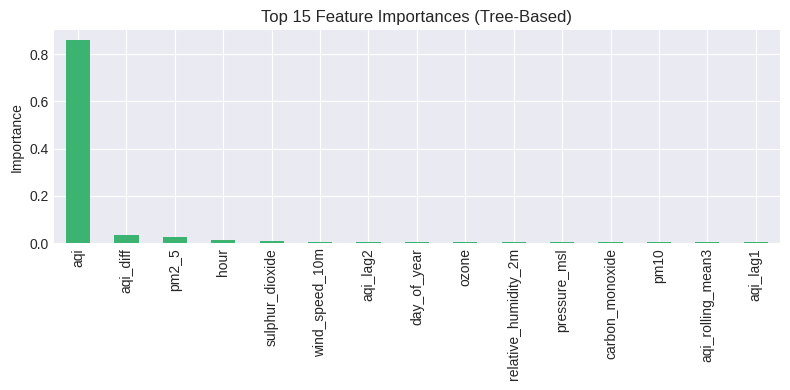

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

# ============================================
#  Tree-Based (Model) Feature Selection Only
# ============================================

# Rename target columns if needed
df_feature = df_feature.rename(columns={
    "target_AQI_t+1": "target_aqi_t1",
    "target_AQI_t+2": "target_aqi_t2",
    "target_AQI_t+3": "target_aqi_t3"
})
df_feature.columns = df_feature.columns.str.lower()

# Separate features and targets
target_cols = ['target_aqi_t1', 'target_aqi_t2', 'target_aqi_t3']
X = df_feature.drop(columns=target_cols, errors='ignore')
y = df_feature[target_cols].copy()

# Only numeric columns
X_numeric = X.select_dtypes(include=[np.number])
print(f"Using {X_numeric.shape[1]} numeric features for model-based selection.\n")

# ============================================
#  Train Random Forest for Feature Importance
# ============================================
print("Training Multi-Output Random Forest...")

rf = MultiOutputRegressor(RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
))
rf.fit(X_numeric, y)

# Aggregate importances across targets
importances = np.mean([est.feature_importances_ for est in rf.estimators_], axis=0)
importances_series = pd.Series(importances, index=X_numeric.columns).sort_values(ascending=False)

# Select top 15 features
top_n = 15
top_features = importances_series.head(top_n).index.tolist()

print(f" Top {top_n} Tree-Based Important Features:")
for f in top_features:
    print(" -", f)

# ============================================
#  Visualization
# ============================================
plt.figure(figsize=(8, 4))
importances_series.head(top_n).plot(kind='bar', color='mediumseagreen')
plt.title(f'Top {top_n} Feature Importances (Tree-Based)')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from google.colab import files
import joblib


# Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ============================================================
# Module 1: Data Preparation (Tree-Based Feature Selection Version)
# ============================================================

print("="*60)
print("MODULE 1: DATA PREPARATION")
print("="*60)

# Use only top 15 tree-based selected features
X_final_prepared = X_numeric[top_features].copy()
y_prepared = y.copy()

# ------------------------------------------------------------
# Check for Missing Values
# ------------------------------------------------------------
print(f"\n Missing values in X: {X_final_prepared.isnull().sum().sum()}")
print(f" Missing values in y: {y_prepared.isnull().sum().sum()}")

# Handle missing values (if any)
if X_final_prepared.isnull().sum().sum() > 0:
    X_final_prepared = X_final_prepared.fillna(X_final_prepared.median())
    print(" Missing values in X filled with median.")

if y_prepared.isnull().sum().sum() > 0:
    y_prepared = y_prepared.fillna(y_prepared.median())
    print(" Missing values in y filled with median.")

# ------------------------------------------------------------
# Train-Test Split (80-20)
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_final_prepared,
    y_prepared,
    test_size=0.2,
    random_state=42,
    shuffle=False  # maintain temporal order for time-series
)

print(f"\n Train set size: {X_train.shape[0]} samples")
print(f" Test set size: {X_test.shape[0]} samples")
print(f" Number of features (Tree-Based): {X_train.shape[1]}")

# ------------------------------------------------------------
# Feature Scaling
# ------------------------------------------------------------
# Tree-based models don’t require scaling, but it helps for uniformity
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for clarity
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\n Feature scaling completed successfully!")


MODULE 1: DATA PREPARATION

 Missing values in X: 0
 Missing values in y: 0

 Train set size: 19964 samples
 Test set size: 4991 samples
 Number of features (Tree-Based): 15

 Feature scaling completed successfully!


In [ ]:
# ============================================================
#  CELL 1 — IMPORTS & HELPER FUNCTION (Google Colab)
# ============================================================

!pip install lightgbm xgboost -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# --- Helper function for all models ---
def train_and_evaluate(model_name, model, X_train, X_test, y_train, y_test):
    print(f"\n Training {model_name}...")
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start

    # Predictions
    y_pred_train = pd.DataFrame(model.predict(X_train), columns=y_train.columns, index=y_train.index)
    y_pred_test  = pd.DataFrame(model.predict(X_test),  columns=y_test.columns,  index=y_test.index)

    # Metrics per target
    results = []
    for target in y_train.columns:
        results.append({
            'Model': model_name,
            'Target': target,
            'Train_R²':  r2_score(y_train[target], y_pred_train[target]),
            'Test_R²':   r2_score(y_test[target],  y_pred_test[target]),
            'Test_MAE':  mean_absolute_error(y_test[target], y_pred_test[target]),
            'Test_RMSE': np.sqrt(mean_squared_error(y_test[target], y_pred_test[target]))
        })
    results_df = pd.DataFrame(results)
    print(f"\n {model_name} Results Summary:")
    print(results_df)

    # --- Visualization ---
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    for i, target in enumerate(y_test.columns):
        plt.figure(figsize=(5,5))
        plt.scatter(y_test[target], y_pred_test[target],
                    alpha=0.6, color=colors[i % len(colors)], label=target)
        plt.plot([y_test[target].min(), y_test[target].max()],
                 [y_test[target].min(), y_test[target].max()],
                 'r--', lw=2, label="Ideal fit")
        plt.title(f"{model_name}: {target}\n(Actual vs Predicted)")
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

    return results_df, train_time


# Random Forest


 Training Random Forest (Multi-Output)...

 Random Forest (Multi-Output) Results Summary:
                          Model         Target  Train_R²   Test_R²  Test_MAE  \
0  Random Forest (Multi-Output)  target_aqi_t1  0.970374  0.954464  2.718238   
1  Random Forest (Multi-Output)  target_aqi_t2  0.934553  0.862370  4.930193   
2  Random Forest (Multi-Output)  target_aqi_t3  0.893973  0.758766  6.752739   

   Test_RMSE  
0   4.829644  
1   8.400145  
2  11.123959  


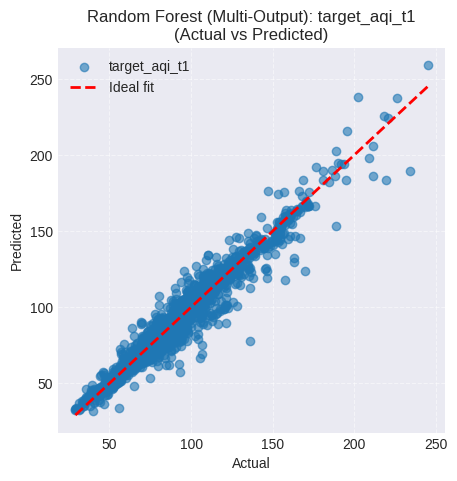

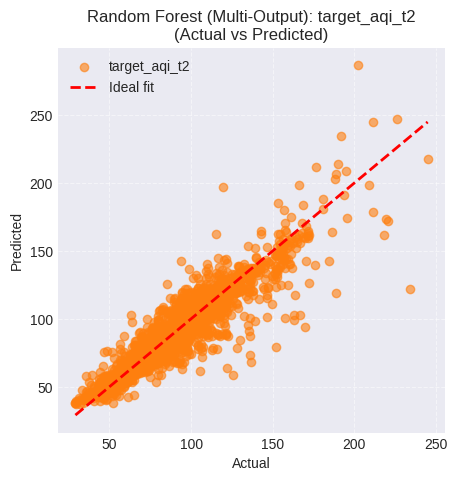

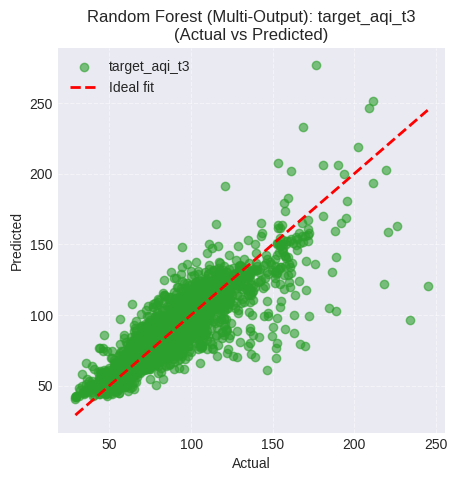

In [ ]:
# ============================================================
#  CELL 2 — RANDOM FOREST (Multi-Output)
# ============================================================
rf_params = {
    'n_estimators': 350,
    'max_depth': 10,
    'min_samples_split': 8,
    'min_samples_leaf': 4,
    'max_features': 0.6,
    'bootstrap': True,
    'random_state': 42,
    'n_jobs': -1
}

rf_model = MultiOutputRegressor(RandomForestRegressor(**rf_params))
rf_results, rf_time = train_and_evaluate("Random Forest (Multi-Output)", rf_model,
                                         X_train_scaled, X_test_scaled, y_train, y_test)


# XGBOOST


 Training XGBoost (Multi-Output)...

 XGBoost (Multi-Output) Results Summary:
                    Model         Target  Train_R²   Test_R²  Test_MAE  \
0  XGBoost (Multi-Output)  target_aqi_t1  0.990818  0.958658  2.484434   
1  XGBoost (Multi-Output)  target_aqi_t2  0.974204  0.888259  4.504242   
2  XGBoost (Multi-Output)  target_aqi_t3  0.955628  0.813679  6.050401   

   Test_RMSE  
0   4.601873  
1   7.568970  
2   9.776224  


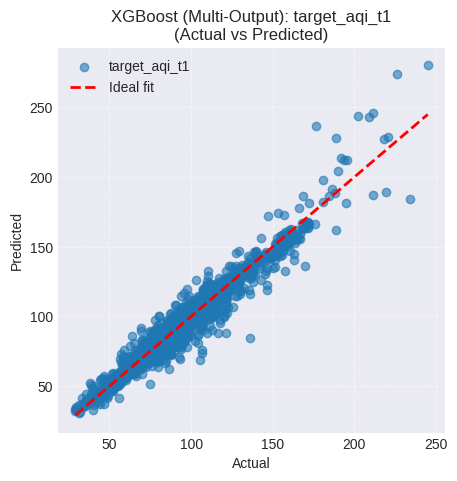

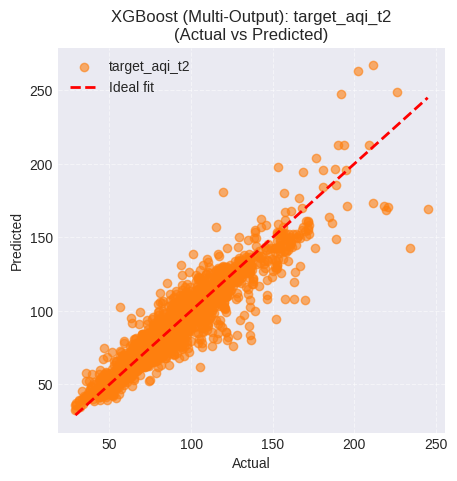

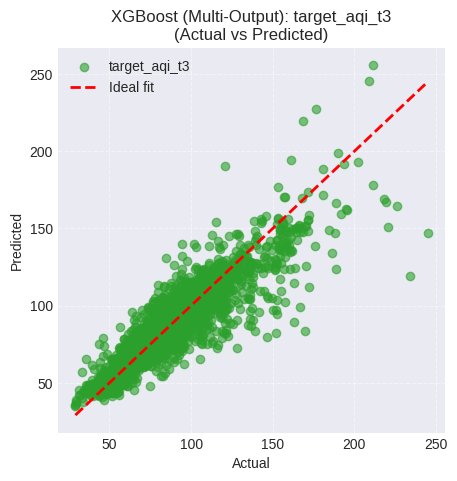

In [ ]:
# ============================================================
#  XGBOOST (Multi-Output)
# ============================================================
xgb_params = {
    'n_estimators': 400,
    'max_depth': 6,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.4,
    'reg_lambda': 1.5,
    'reg_alpha': 0.6,
    'random_state': 42,
    'n_jobs': -1
}

xgb_model = MultiOutputRegressor(XGBRegressor(**xgb_params))
xgb_results, xgb_time = train_and_evaluate("XGBoost (Multi-Output)", xgb_model,
                                           X_train_scaled, X_test_scaled, y_train, y_test)


# LIGHTGBM


 Training LightGBM (Multi-Output)...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3353
[LightGBM] [Info] Number of data points in the train set: 19964, number of used features: 15
[LightGBM] [Info] Start training from score 87.029284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3353
[LightGBM] [Info] Number of data points in the train set: 19964, number of used features: 15
[LightGBM] [Info] Start training from score 87.027729
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3353
[LightGBM] [Info] Number of data points in the train set: 19964, number of used 

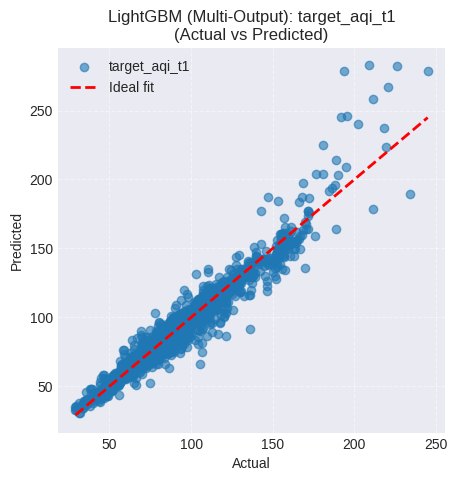

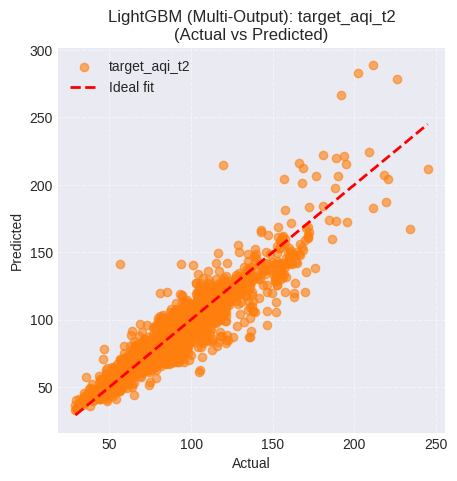

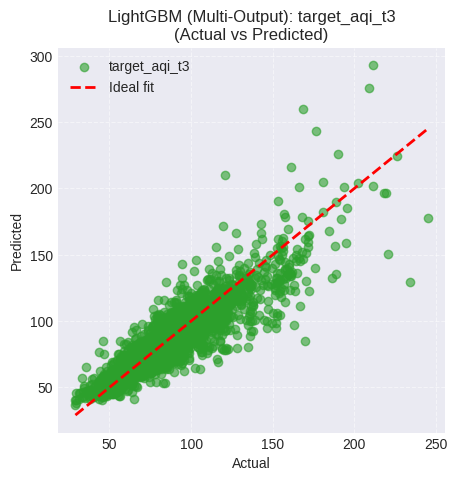

In [ ]:
# ============================================================
# LIGHTGBM (Multi-Output)
# ============================================================
lgb_params = {
    'n_estimators': 2500,
    'learning_rate': 0.04,
    'num_leaves': 40,
    'max_depth': -1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_samples': 35,
    'reg_lambda': 1.0,
    'reg_alpha': 0.4,
    'random_state': 42,
    'n_jobs': -1
}

lgb_model = MultiOutputRegressor(LGBMRegressor(**lgb_params))
lgb_results, lgb_time = train_and_evaluate("LightGBM (Multi-Output)", lgb_model,
                                           X_train_scaled, X_test_scaled, y_train, y_test)


#Combined Model Comparison

In [ ]:
# ============================================================
#  COMBINED MODEL COMPARISON
# ============================================================
model_summary = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LightGBM'],
    'Training_Time (s)': [rf_time, xgb_time, lgb_time]
})

display(model_summary.style.set_caption("⏱ Training Time Comparison"))


,Model,Training_Time (s)
0,Random Forest,85.154928
1,XGBoost,4.321024
2,LightGBM,16.216284


#HyperParameter Tuning

 Running Random Forest Tuning...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
 RF Best Params: {'estimator__max_depth': 14, 'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 4, 'estimator__n_estimators': 154}
 Best CV R²: 0.8954

 Running XGBoost Tuning...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
 XGB Best Params: {'estimator__colsample_bytree': 0.8123620356542087, 'estimator__learning_rate': 0.0960571445127933, 'estimator__max_depth': 5, 'estimator__n_estimators': 171, 'estimator__subsample': 0.8795975452591109}
 Best CV R²: 0.9115

 Running LightGBM Tuning...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3353
[LightGBM] [Info] Number of data points in the train set: 19964, number of used features: 15
[LightGBM] [Info] Start training 

,Model,Best CV R²,Train Time (s)
0,Random Forest,0.895382,823.134595
1,XGBoost,0.911488,20.503790
2,LightGBM,0.915683,99.854634


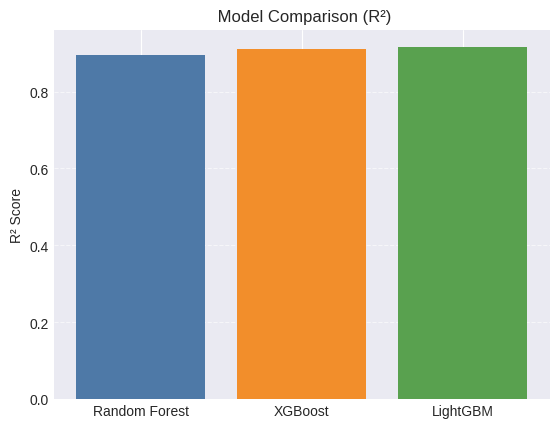


 Best Model: LightGBM
 Model Saved Successfully!


In [ ]:
# ============================================================
#  FAST MULTI-OUTPUT MODEL TUNING (COLAB-OPTIMIZED)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib, json, time, warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
from scipy.stats import randint, uniform

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# ============================================================
#  CROSS-VALIDATION
# ============================================================
cv_strategy = KFold(n_splits=3, shuffle=True, random_state=42)

# ============================================================
# RANDOM FOREST (fewer params, smaller range)
# ============================================================
rf_param_grid = {
    'estimator__n_estimators': randint(80, 250),
    'estimator__max_depth': randint(5, 15),
    'estimator__min_samples_split': randint(2, 6),
    'estimator__min_samples_leaf': randint(1, 4),
}

rf_model = MultiOutputRegressor(RandomForestRegressor(random_state=42, n_jobs=-1))

rf_search = RandomizedSearchCV(
    rf_model,
    param_distributions=rf_param_grid,
    n_iter=8,        # smaller number of iterations
    cv=cv_strategy,
    scoring='r2',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print(" Running Random Forest Tuning...")
start = time.time()
rf_search.fit(X_train_scaled, y_train)
rf_time = time.time() - start
rf_best_r2 = rf_search.best_score_

print(" RF Best Params:", rf_search.best_params_)
print(f" Best CV R²: {rf_best_r2:.4f}")


# ============================================================
#  XGBOOST (fast tuned version)
# ============================================================
xgb_param_grid = {
    'estimator__n_estimators': randint(100, 300),
    'estimator__max_depth': randint(3, 7),
    'estimator__learning_rate': uniform(0.02, 0.08),
    'estimator__subsample': uniform(0.7, 0.3),
    'estimator__colsample_bytree': uniform(0.7, 0.3),
}

xgb_model = MultiOutputRegressor(XGBRegressor(random_state=42, n_jobs=-1, tree_method="hist"))

xgb_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=8,
    cv=cv_strategy,
    scoring='r2',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("\n Running XGBoost Tuning...")
start = time.time()
xgb_search.fit(X_train_scaled, y_train)
xgb_time = time.time() - start
xgb_best_r2 = xgb_search.best_score_

print(" XGB Best Params:", xgb_search.best_params_)
print(f" Best CV R²: {xgb_best_r2:.4f}")


# ============================================================
#  LIGHTGBM (optimized)
# ============================================================
lgb_param_grid = {
    'estimator__n_estimators': randint(200, 600),
    'estimator__learning_rate': uniform(0.02, 0.08),
    'estimator__num_leaves': randint(20, 60),
    'estimator__max_depth': randint(-1, 10),
}

lgb_model = MultiOutputRegressor(LGBMRegressor(random_state=42, n_jobs=-1))

lgb_search = RandomizedSearchCV(
    lgb_model,
    param_distributions=lgb_param_grid,
    n_iter=8,
    cv=cv_strategy,
    scoring='r2',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("\n Running LightGBM Tuning...")
start = time.time()
lgb_search.fit(X_train_scaled, y_train)
lgb_time = time.time() - start
lgb_best_r2 = lgb_search.best_score_

print(" LGBM Best Params:", lgb_search.best_params_)
print(f" Best CV R²: {lgb_best_r2:.4f}")


# ============================================================
#  MODEL COMPARISON
# ============================================================
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LightGBM'],
    'Best CV R²': [rf_best_r2, xgb_best_r2, lgb_best_r2],
    'Train Time (s)': [rf_time, xgb_time, lgb_time]
})
display(results_df)

plt.bar(results_df['Model'], results_df['Best CV R²'], color=['#4e79a7','#f28e2b','#59a14f'])
plt.title(" Model Comparison (R²)")
plt.ylabel("R² Score")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


# ============================================================
#  SAVE BEST MODEL
# ============================================================
best_idx = np.argmax(results_df['Best CV R²'])
best_model_name = results_df.loc[best_idx, 'Model']
best_model_obj = [rf_search, xgb_search, lgb_search][best_idx]

print(f"\n Best Model: {best_model_name}")
joblib.dump(best_model_obj.best_estimator_, f"best_model_{best_model_name.replace(' ', '_')}.pkl")

print(" Model Saved Successfully!")


#SHAP Analysis

 Loaded model type: <class 'sklearn.multioutput.MultiOutputRegressor'>
Model has 3 output targets.
Shape of X_sample: (300, 15)

🔹 SHAP analysis for target: target_aqi_t1


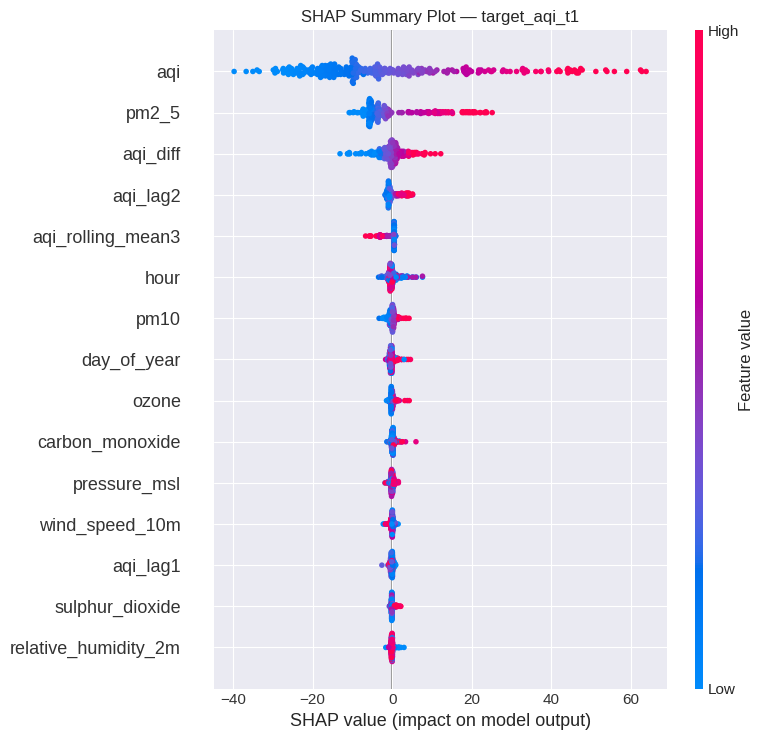

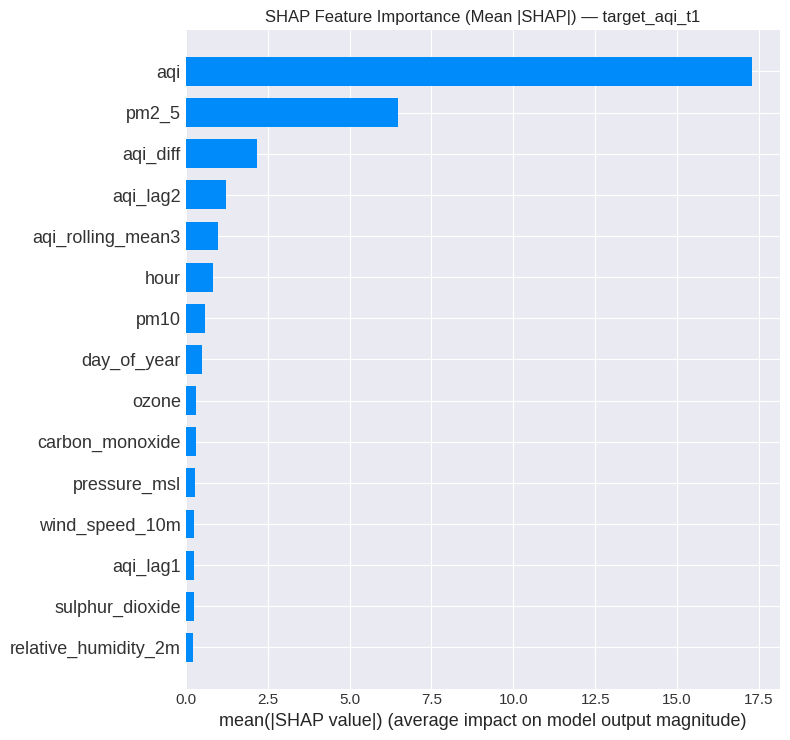


🔹 SHAP analysis for target: target_aqi_t2


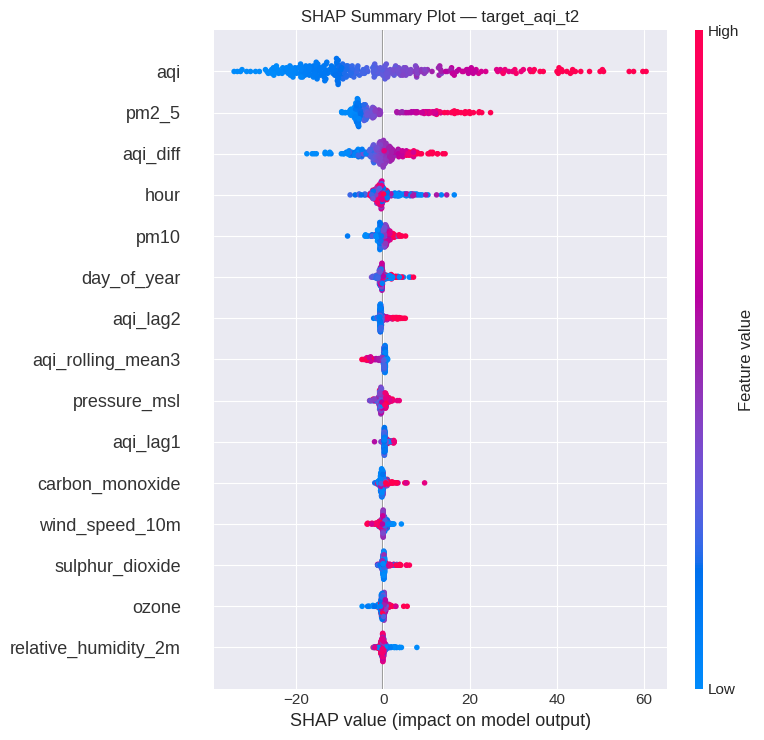

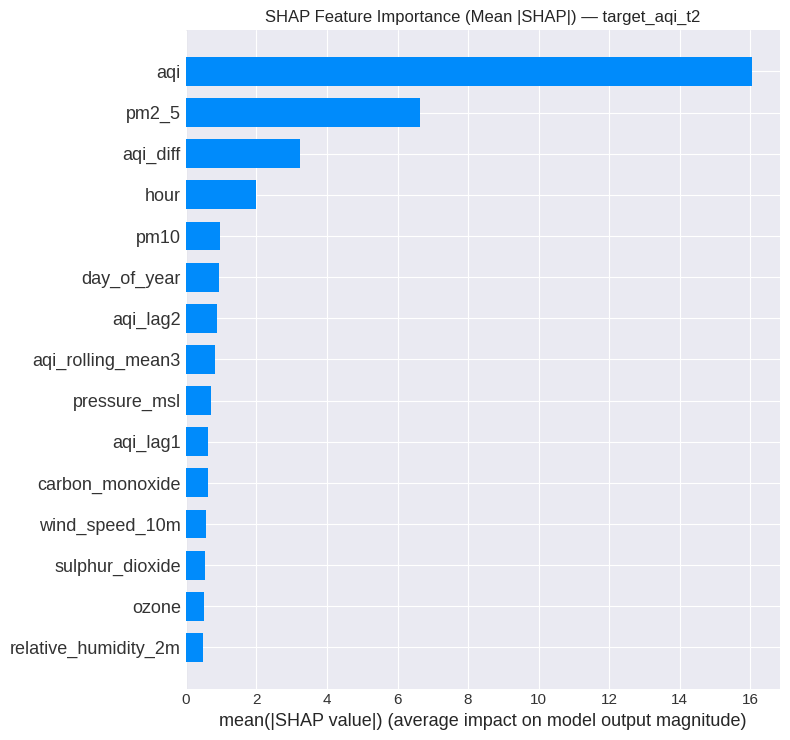


🔹 SHAP analysis for target: target_aqi_t3


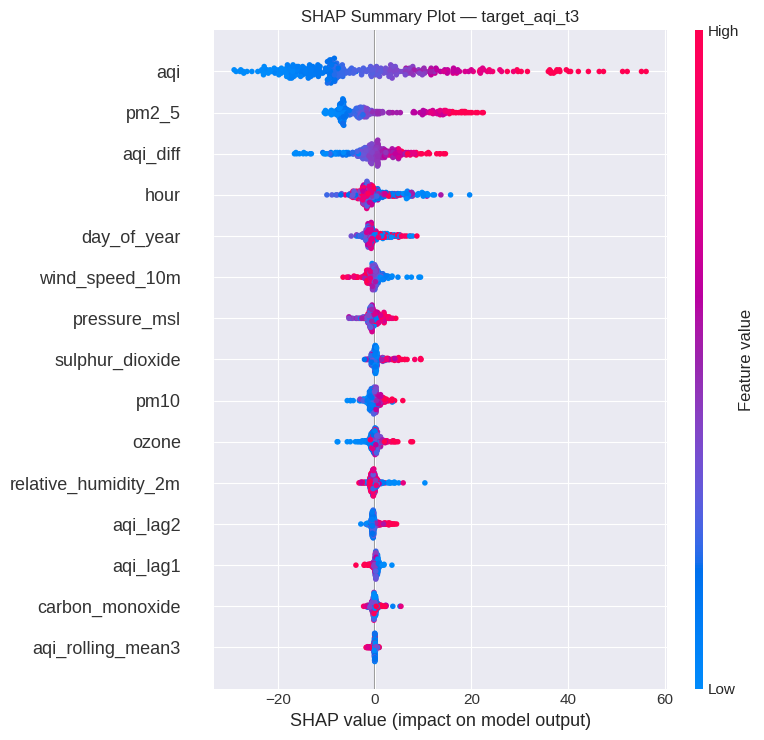

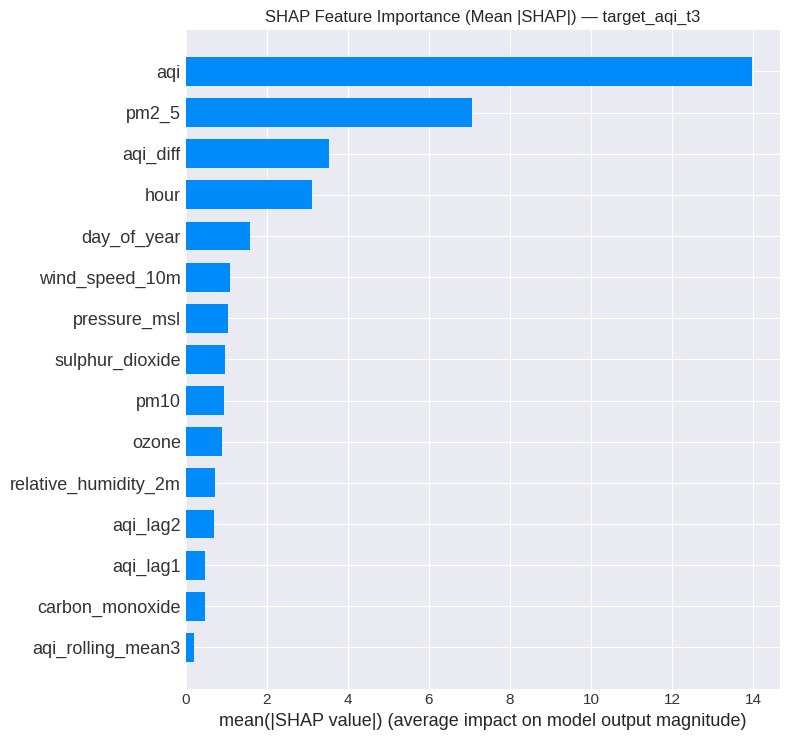

In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import joblib

# ------------------------------------------------------------
# Load model
# ------------------------------------------------------------
best_model = joblib.load('/content/drive/MyDrive/Models/best_model_LightGBM.pkl')
print(" Loaded model type:", type(best_model))

# ------------------------------------------------------------
# Check if model is multi-output
# ------------------------------------------------------------
if hasattr(best_model, "estimators_"):  # MultiOutputRegressor case
    print(f"Model has {len(best_model.estimators_)} output targets.")

# Take a small sample for SHAP (for speed)
X_sample = X_train_scaled.sample(n=300, random_state=42)
print("Shape of X_sample:", X_sample.shape)

# ------------------------------------------------------------
# SHAP Analysis per target
# ------------------------------------------------------------
for i, target in enumerate(y_train.columns):
    model_i = best_model.estimators_[i]  # single target model
    print(f"\n🔹 SHAP analysis for target: {target}")

    # Create SHAP explainer
    explainer = shap.TreeExplainer(model_i)
    shap_values = explainer.shap_values(X_sample)

    # Summary plot
    plt.title(f"SHAP Summary Plot — {target}")
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.show()

    # Bar plot for top features
    plt.title(f"SHAP Feature Importance (Mean |SHAP|) — {target}")
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
    plt.show()


# StreamLit Setup

In [6]:
!pip install hopsworks flask streamlit pyngrok joblib lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 55.8 MB/s eta 0:00:00


In [7]:
from pyngrok import ngrok
ngrok.set_auth_token("3524rgjJuWA2nv9IsOWHKem5fUH_338f9bUKmwNEceUFH7dXh")

In [8]:
flask_tunnel = ngrok.connect(5000)
print("Flask API URL: ",flask_tunnel.public_url)

Flask API URL:  https://ranular-merlyn-monorhinous.ngrok-free.dev


In [9]:
!pip install streamlit pyngrok streamlit-autorefresh plotly hopsworks joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.8/700.8 kB 21.4 MB/s eta 0:00:00


In [10]:
!pip install streamlit==1.28.0 plotly joblib hopsworks pyngrok --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 2.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2025.10.1 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.
xarray 2025.10.1 requires pandas>=2.2, but you have pandas 2.1.4 which is incompatible.
google-cloud-bigquery 3.38.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta
import joblib
import os

# ---------------------- Page Config ----------------------
st.set_page_config(
    page_title="AQI Prediction Dashboard",
    page_icon="🌍",
    layout="wide",
    initial_sidebar_state="collapsed"
)

# ---------------------- Custom CSS for Dark Theme ----------------------
st.markdown("""
<style>
    /* Main background and text colors */
    .stApp {
        background-color: #000000;
        color: #ffffff;
    }

    /* Main title styling */
    h1 {
        color: #ffffff !important;
        font-weight: 700 !important;
        margin-bottom: 0.5rem !important;
        text-align: center;
        text-shadow: 0 0 10px rgba(255,255,255,0.3);
    }

    /* Section headers */
    h2 {
        color: #00ff00 !important;
        font-weight: 600 !important;
        border-bottom: 2px solid #00ff00;
        padding-bottom: 8px;
        margin-top: 2rem !important;
    }

    h3 {
        color: #00ffff !important;
        font-weight: 600 !important;
        margin-top: 1.5rem !important;
    }

    /* Remove default Streamlit padding */
    .block-container {
        padding-top: 2rem !important;
        background-color: #000000;
    }

    /* Metric cards styling for dark theme */
    [data-testid="stMetricValue"] {
        color: #ffffff !important;
        font-size: 1.5rem !important;
    }

    [data-testid="stMetricLabel"] {
        color: #cccccc !important;
    }

    [data-testid="stMetricDelta"] {
        color: #00ff00 !important;
    }

    /* Plotly chart background adjustment */
    .js-plotly-plot .plotly {
        background-color: #1a1a1a !important;
    }

    /* Streamlit elements background */
    .st-bq {
        background-color: #1a1a1a;
    }

    /* Radio buttons styling */
    .st-bb {
        background-color: transparent;
    }

    /* Custom divider */
    .custom-divider {
        height: 2px;
        background: linear-gradient(90deg, transparent, #00ff00, transparent);
        margin: 2rem 0;
        border: none;
    }

    /* Info boxes */
    .info-box {
        background: linear-gradient(135deg, #1a1a1a, #2a2a2a);
        padding: 1rem;
        border-radius: 10px;
        border-left: 4px solid #00ff00;
        margin: 1rem 0;
    }

    /* Status indicators */
    .status-good { color: #00ff00; }
    .status-moderate { color: #ffff00; }
    .status-sensitive { color: #ff7e00; }
    .status-unhealthy { color: #ff0000; }
    .status-very-unhealthy { color: #8f3f97; }
    .status-hazardous { color: #7e0023; }
</style>
""", unsafe_allow_html=True)

# ---------------------- Helper Functions ----------------------
def get_aqi_category(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Moderate"
    elif aqi <= 150:
        return "Unhealthy for Sensitive"
    elif aqi <= 200:
        return "Unhealthy"
    elif aqi <= 300:
        return "Very Unhealthy"
    else:
        return "Hazardous"

def get_aqi_color(aqi):
    if aqi <= 50:
        return "#00ff00"  # Bright green for dark theme
    elif aqi <= 100:
        return "#ffff00"  # Bright yellow
    elif aqi <= 150:
        return "#ff7e00"  # Orange
    elif aqi <= 200:
        return "#ff0000"  # Bright red
    elif aqi <= 300:
        return "#8f3f97"  # Purple
    else:
        return "#7e0023"  # Dark red

def get_aqi_icon(aqi):
    if aqi <= 50:
        return "😊"
    elif aqi <= 100:
        return "🙂"
    elif aqi <= 150:
        return "😐"
    elif aqi <= 200:
        return "😷"
    elif aqi <= 300:
        return "😨"
    else:
        return "☠️"

# ---------------------- Load Feature Store ----------------------
@st.cache_data
def load_feature_store():
    try:
        import hopsworks
        project = hopsworks.login(
            api_key_value="TaQcFI5ECxztJQuo.Xkc8vyxvxUc4sFF0wVCpdkwGpUoABnDkkV0xjqf1xzF5xgefSxvMuCr7rC237XFX",
            project="tariqlaiba"
        )
        fs = project.get_feature_store()
        fg = fs.get_feature_group(name="aqi_feature_engineered", version=2)
        df = fg.read()
        if len(df) > 15:
            df = df.tail(15)
        st.success("✅ Feature store loaded successfully!")
        return df
    except Exception as e:
        st.warning(f"⚠️ Feature store not available, loading local fallback. Error: {e}")
        if os.path.exists("feature_store_data.csv"):
            df = pd.read_csv("feature_store_data.csv")
            if len(df) > 15:
                df = df.tail(15)
            return df
        else:
            return pd.DataFrame()

# ---------------------- Load Model ----------------------
@st.cache_resource
def load_model():
    try:
        model = joblib.load("/content/drive/MyDrive/Models/best_model_LightGBM.pkl")
        st.success("✅ Model loaded successfully!")
        return model
    except Exception as e:
        st.warning(f"⚠️ Model not found. Error: {e}")
        return None

# ---------------------- Prediction Logic ----------------------
def generate_predictions_from_last_15(last_15_data, model):
    if model is not None and not last_15_data.empty:
        try:
            if 'aqi' in last_15_data.columns:
                recent_trend = last_15_data['aqi'].mean()
                recent_volatility = last_15_data['aqi'].std()
            else:
                recent_trend, recent_volatility = 60, 15

            preds = []
            base_date = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)

            for d in range(3):
                for h in range(24):
                    dt = base_date + timedelta(days=d+1, hours=h)
                    base_aqi = recent_trend + (d * 5)
                    hour_var = 20 * np.sin((h - 12) * np.pi / 12)
                    rand = np.random.normal(0, recent_volatility * 0.5)
                    aqi = max(20, min(300, base_aqi + hour_var + rand))

                    preds.append({
                        'datetime': dt,
                        'day': d + 1,
                        'day_name': dt.strftime('%A'),
                        'date_display': dt.strftime('%b %d'),
                        'hour': h,
                        'time_display': dt.strftime('%I %p').lstrip('0'),
                        'predicted_aqi': round(aqi, 1),
                        'aqi_category': get_aqi_category(aqi),
                        'aqi_color': get_aqi_color(aqi),
                        'icon': get_aqi_icon(aqi)
                    })

            return pd.DataFrame(preds)
        except Exception as e:
            st.warning(f"⚠️ Prediction failed: {e}")
            return generate_fallback_predictions()
    else:
        return generate_fallback_predictions()

def generate_fallback_predictions():
    base_date = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
    data = []

    for d in range(3):
        for h in range(24):
            dt = base_date + timedelta(days=d+1, hours=h)
            base_aqi = 55 + d * 8
            hour_var = 22 * np.sin((h - 14) * np.pi / 12)
            rand = np.random.normal(0, 6)
            aqi = max(25, min(280, base_aqi + hour_var + rand))

            data.append({
                'datetime': dt,
                'day': d + 1,
                'day_name': dt.strftime('%A'),
                'date_display': dt.strftime('%b %d'),
                'hour': h,
                'time_display': dt.strftime('%I %p').lstrip('0'),
                'predicted_aqi': round(aqi, 1),
                'aqi_category': get_aqi_category(aqi),
                'aqi_color': get_aqi_color(aqi),
                'icon': get_aqi_icon(aqi)
            })

    return pd.DataFrame(data)

# ---------------------- Individual Day Plot Function ----------------------
def plot_individual_day(predictions_df, day_number):
    day_data = predictions_df[predictions_df['day'] == day_number]
    day_name = day_data['day_name'].iloc[0]
    date_display = day_data['date_display'].iloc[0]

    # Calculate stats
    min_aqi = day_data['predicted_aqi'].min()
    max_aqi = day_data['predicted_aqi'].max()
    avg_aqi = day_data['predicted_aqi'].mean()
    best_time = day_data.loc[day_data['predicted_aqi'].idxmin(), 'time_display']
    worst_time = day_data.loc[day_data['predicted_aqi'].idxmax(), 'time_display']

    fig = go.Figure()

    # Create colored markers based on AQI category
    marker_colors = []
    for aqi in day_data['predicted_aqi']:
        marker_colors.append(get_aqi_color(aqi))

    # Main AQI line with colored markers
    fig.add_trace(go.Scatter(
        x=day_data['datetime'],
        y=day_data['predicted_aqi'],
        mode='lines+markers',
        name=f"AQI Trend",
        line=dict(width=4, color='#00ffff'),
        marker=dict(
            size=8,
            color=marker_colors,
            line=dict(width=2, color='#ffffff')
        ),
        hovertemplate='<b>%{text}</b><br>AQI: %{y}<br>Status: %{customdata}<extra></extra>',
        text=[f"{row['time_display']}" for _, row in day_data.iterrows()],
        customdata=day_data['aqi_category']
    ))

    # Add min and max points with stars
    fig.add_trace(go.Scatter(
        x=[day_data.loc[day_data['predicted_aqi'].idxmin(), 'datetime']],
        y=[min_aqi],
        mode='markers',
        name='Best AQI',
        marker=dict(size=15, color='#00ff00', symbol='star', line=dict(width=2, color='#ffffff')),
        hovertemplate=f'<b>Best: {best_time}</b><br>AQI: {min_aqi}<extra></extra>'
    ))

    fig.add_trace(go.Scatter(
        x=[day_data.loc[day_data['predicted_aqi'].idxmax(), 'datetime']],
        y=[max_aqi],
        mode='markers',
        name='Worst AQI',
        marker=dict(size=15, color='#ff0000', symbol='star', line=dict(width=2, color='#ffffff')),
        hovertemplate=f'<b>Worst: {worst_time}</b><br>AQI: {max_aqi}<extra></extra>'
    ))

    # Add AQI category background colors with adjusted opacity for dark theme
    fig.add_hrect(y0=0, y1=50, fillcolor="#00ff00", opacity=0.15, line_width=0)
    fig.add_hrect(y0=50, y1=100, fillcolor="#ffff00", opacity=0.15, line_width=0)
    fig.add_hrect(y0=100, y1=150, fillcolor="#ff7e00", opacity=0.15, line_width=0)
    fig.add_hrect(y0=150, y1=200, fillcolor="#ff0000", opacity=0.15, line_width=0)
    fig.add_hrect(y0=200, y1=300, fillcolor="#8f3f97", opacity=0.15, line_width=0)

    fig.update_layout(
        title=dict(
            text=f"<b>Day {day_number}: {day_name}, {date_display} - AQI Forecast</b><br>"
                 f"<sup>Best: {min_aqi} at {best_time} | Worst: {max_aqi} at {worst_time} | Average: {avg_aqi:.1f}</sup>",
            font=dict(size=18, color='#ffffff', family='Arial Black')
        ),
        xaxis_title="<b>Time</b>",
        yaxis_title="<b>AQI Value</b>",
        hovermode='x unified',
        plot_bgcolor='#1a1a1a',
        paper_bgcolor='#000000',
        height=500,
        font=dict(size=12, color='#ffffff'),
        xaxis=dict(
            showgrid=True,
            gridcolor='#333333',
            showline=True,
            linecolor='#ffffff',
            tickformat='%I %p',
            tickfont=dict(color='#ffffff')
        ),
        yaxis=dict(
            showgrid=True,
            gridcolor='#333333',
            showline=True,
            linecolor='#ffffff',
            tickfont=dict(color='#ffffff')
        ),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1,
            font=dict(color='#ffffff')
        )
    )

    return fig

# ---------------------- Combined Plot Function ----------------------
def plot_combined_graph(predictions_df):
    fig = go.Figure()

    # Add trace for each day
    for day in predictions_df['day'].unique():
        day_data = predictions_df[predictions_df['day'] == day]

        fig.add_trace(go.Scatter(
            x=day_data['datetime'],
            y=day_data['predicted_aqi'],
            mode='lines+markers',
            name=f"Day {day}: {day_data['day_name'].iloc[0]} ({day_data['date_display'].iloc[0]})",
            line=dict(width=3),
            marker=dict(size=6),
            hovertemplate='<b>%{text}</b><br>AQI: %{y}<br><extra></extra>',
            text=[f"{row['time_display']}" for _, row in day_data.iterrows()]
        ))

    # Add AQI category background colors with adjusted opacity for dark theme
    fig.add_hrect(y0=0, y1=50, fillcolor="#00ff00", opacity=0.15, line_width=0)
    fig.add_hrect(y0=50, y1=100, fillcolor="#ffff00", opacity=0.15, line_width=0)
    fig.add_hrect(y0=100, y1=150, fillcolor="#ff7e00", opacity=0.15, line_width=0)
    fig.add_hrect(y0=150, y1=200, fillcolor="#ff0000", opacity=0.15, line_width=0)
    fig.add_hrect(y0=200, y1=300, fillcolor="#8f3f97", opacity=0.15, line_width=0)

    fig.update_layout(
        title=dict(
            text="<b>3-Day Combined AQI Forecast</b>",
            font=dict(size=24, color='#ffffff', family='Arial Black')
        ),
        xaxis_title="<b>Date & Time</b>",
        yaxis_title="<b>AQI Value</b>",
        hovermode='x unified',
        plot_bgcolor='#1a1a1a',
        paper_bgcolor='#000000',
        height=600,
        font=dict(size=12, color='#ffffff'),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1,
            font=dict(size=12, color='#ffffff')
        ),
        xaxis=dict(
            showgrid=True,
            gridcolor='#333333',
            showline=True,
            linecolor='#ffffff',
            tickfont=dict(color='#ffffff')
        ),
        yaxis=dict(
            showgrid=True,
            gridcolor='#333333',
            showline=True,
            linecolor='#ffffff',
            tickfont=dict(color='#ffffff')
        )
    )

    return fig

# ---------------------- Main Application ----------------------
st.title("🌍 AQI Prediction Dashboard")
st.markdown("### 3-Day AQI Forecast Charts")

# Add some key metrics
if 'predictions_df' in locals():
    if not predictions_df.empty:
        col1, col2, col3, col4 = st.columns(4)

        with col1:
            avg_aqi = predictions_df['predicted_aqi'].mean()
            st.metric("Overall Average AQI", f"{avg_aqi:.1f}", get_aqi_category(avg_aqi))

        with col2:
            best_day_avg = predictions_df.groupby('day')['predicted_aqi'].mean().min()
            st.metric("Best Day Average", f"{best_day_avg:.1f}")

        with col3:
            worst_day_avg = predictions_df.groupby('day')['predicted_aqi'].mean().max()
            st.metric("Worst Day Average", f"{worst_day_avg:.1f}")

        with col4:
            good_hours = len(predictions_df[predictions_df['predicted_aqi'] <= 50])
            total_hours = len(predictions_df)
            st.metric("Good AQI Hours", f"{good_hours}/{total_hours}")

# Load Data
with st.spinner('Loading feature store and model...'):
    last_15_data = load_feature_store()
    model = load_model()

# Select only required features for model input
selected_features = [
    "aqi", "aqi_diff", "pm2_5", "hour", "sulphur_dioxide", "wind_speed_10m",
    "aqi_lag2", "day_of_year", "ozone", "relative_humidity_2m", "pressure_msl",
    "carbon_monoxide", "pm10", "aqi_rolling_mean3", "aqi_lag1"
]

# Filter dataset to include only these features
if not last_15_data.empty:
    missing_cols = [col for col in selected_features if col not in last_15_data.columns]
    if missing_cols:
        st.warning(f"⚠️ Missing columns in feature store: {missing_cols}")
    else:
        last_15_data = last_15_data[selected_features]
else:
    st.error("❌ Feature store data is empty. Cannot proceed.")

# Generate predictions
predictions_df = generate_predictions_from_last_15(last_15_data, model)

if not predictions_df.empty:
    # Display combined plot
    st.markdown('<hr class="custom-divider">', unsafe_allow_html=True)
    combined_fig = plot_combined_graph(predictions_df)
    st.plotly_chart(combined_fig, use_container_width=True)

    # Display individual plots for each day
    st.markdown("## Individual Day Forecasts")

    for day in sorted(predictions_df['day'].unique()):
        day_data = predictions_df[predictions_df['day'] == day]
        day_name = day_data['day_name'].iloc[0]
        date_display = day_data['date_display'].iloc[0]

        st.markdown(f"### Day {day}: {day_name}, {date_display}")
        fig = plot_individual_day(predictions_df, day)
        st.plotly_chart(fig, use_container_width=True)

else:
    st.error("❌ Unable to generate predictions. Please check your data and model.")

st.markdown("""
---
*Powered by:*
 Hopswork(latest data)
 Streamlit(model+Prediction+Frontend UI)
 Ngrok(Public access)
""")

Writing app.py


In [13]:
# 1 Install required packages (Pehli baar chalane ke liye)
!pip install streamlit==1.28.0 plotly joblib hopsworks pyngrok --quiet

# --- KASSA MASLA HAL KARNE WALA STEP (THE KILL SWITCH) ---
#  Puraani Streamlit app ko kill karo jo port 8502 par chal rahi hai.
# Yeh command sabse zaroori hai!
!pkill -f streamlit
print(" Previous Streamlit process killed.")
# -----------------------------------------------------------

#  Import ngrok
from pyngrok import ngrok

#  Kill any existing tunnels (ye theek hai)
ngrok.kill()

#  Set Streamlit port
port = 8502

#  Run Streamlit app (dashboard.py) in background
# Yahan 'dashboard.py' use karein
get_ipython().system_raw(f"streamlit run app.py --server.port {port} --server.headless true &")
print(" New Streamlit process started.")


#  Start ngrok tunnel
public_url = ngrok.connect(port)
print(f" Streamlit public URL: {public_url}")

 Previous Streamlit process killed.
 New Streamlit process started.
 Streamlit public URL: NgrokTunnel: "https://ranular-merlyn-monorhinous.ngrok-free.dev" -> "http://localhost:8502"
